# Fase 1 - Business Understanding

El banco Monopoly, con una larga trayectoria en el mercado chileno, ha sido recientemente adquirido por la entidad financiera internacional Dormammu. Ante este cambio, Dormammu ha encomendado a su equipo de ingenieros de datos la tarea de analizar exhaustivamente la base de clientes de Monopoly. El objetivo principal es comprender los hábitos financieros de esta nueva clientela y diseñar estrategias personalizadas que permitan una integración exitosa al ecosistema de Dormammu. Para ello, se ha puesto a disposición de los ingenieros una base de datos que abarca un año de información transaccional de una muestra representativa de clientes de Monopoly. La labor del equipo consiste en limpiar y analizar estos datos, identificando patrones de consumo, preferencias y necesidades financieras. Con esta información, se busca generar insights valiosos que permitan a Dormammu diseñar una oferta de productos y servicios a medida, optimizando así la experiencia del cliente y maximizando la rentabilidad.

Para esto, como equipo analista de datos vamos a darle respuesta a las siguientes incognitas:

- ¿Cuáles son los 3 meses de mayor uso de tarjetas de crédito a nivel nacional e internacional?
- ¿Existen diferentes grupos de clientes basados en su comportamiento financiero, como el uso de tarjetas de crédito, nivel de deuda y productos contratados?
- ¿Cuál es la probabilidad de que los clientes con ciertas características demográficas o comportamiento histórico caigan en mora?
- ¿Los clientes con mayor antigüedad o que usan múltiples productos son más fieles al banco?
- ¿Los clientes con dualidad (dos o más tarjetas de crédito) son más propensos a utilizar servicios adicionales como avances en cuotas o compras internacionales?

Con lo expuesto anteriormente, se espera responder satisfactoriamente a estas preguntas para que el nuevo dueño del banco pueda tener información sólida y conocer a mayor profundidad las interacciones económicas de sus clientes.

# Fase 2 - Data Understanding

### A continuación se importarán las librerías necesarias para trabajar en esta metodología.




In [1]:
#Importación de librerias

%pip install pyarrow
%pip install tpot
%pip install --upgrade setuptools
%pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
%pip install ipywidgets

import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from tpot import TPOTClassifier, TPOTRegressor
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# OPCIONAL
### Se realiza conversión del archivo "Base_clientes_Monopoly.xlsx", al formato de archivo '.parquet', para una mayor eficiencia en la carga y análisis de los datos.

In [ ]:
# NO BORRAR - RUTAS DE ARCHIVO DE LOS INTEGRANTES DEL EQUIPO

#df = pd.read_excel("C:/Users/new11/Documents/DUOC - Ing. Informática/2024/2024-2/Machine Learning/Dataset Monopoly.xlsx", engine='openpyxl', sheet_name='Transición de Negocio', header=0)
#df = pd.read_excel("/Users/herna/Desktop/Duoc_UC/6to SEMESTRE/Machine_Learning/ET/Base_clientes_Monopoly.xlsx", engine='openpyxl', sheet_name='Transición de Negocio', header=0)

# ESTABLECER RUTA DEL EXCEL PARA CARGAR EL ARCHIVO
ruta_excel = '/Users/herna/Desktop/Duoc_UC/6to SEMESTRE/Machine_Learning/ET/Base_clientes_Monopoly.xlsx'
df = pd.read_excel(ruta_excel, engine='openpyxl')
df.columns = df.iloc[0]
df1 = df.iloc[1:].reset_index(drop=True)

# ESTABLECER RUTA DE SALIDA DEL ARCHIVO PARQUET
ruta_parquet = '/Users/herna/Desktop/Duoc_UC/6to SEMESTRE/Machine_Learning/ET/Base_clientes_Monopoly.parquet'
df1.to_parquet(ruta_parquet, engine='pyarrow')  # O usa 'fastparquet' si prefieres esa opción

print(f"Archivo convertido y guardado en {ruta_parquet}")


### Se establece la ruta de carga para el archivo parquet.

In [63]:
# NO BORRAR - RUTAS DE ARCHIVO DE LOS INTEGRANTES DEL EQUIPO

# df = pd.read_parquet('/Users/herna/Desktop/Duoc_UC/6to SEMESTRE/Machine_Learning/ET/Base_clientes_Monopoly.parquet', engine='pyarrow')
df = pd.read_parquet("C:/Users/new11/Documents/DUOC - Ing. Informática/2024/2024-2/Machine Learning/Datos Banco Monopoly/Base_clientes_Monopoly.parquet", engine='pyarrow')
df.head(10)

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target,nan
0,1,160,M,13.0,43,NaN,130,1,1,0,...,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0,NaN
1,2,160,H,13.0,46,143640.0,69,1,0,0,...,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0,NaN
2,3,170,H,13.0,45,929106.0,24,1,1,0,...,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0,NaN
3,4,151,H,13.0,46,172447.0,134,0,1,0,...,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0,NaN
4,5,170,H,13.0,46,805250.0,116,0,1,1,...,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0,NaN
5,6,170,H,13.0,47,707664.0,67,1,1,0,...,35800,0.0,35800.0,0.0,0.0,51197,0.0,R,0,NaN
6,7,811,H,13.0,48,1022833.0,21,1,0,1,...,9391,0.0,8818.0,0.0,8818.0,0,0.0,T,0,NaN
7,8,170,H,13.0,46,NaN,69,0,1,1,...,6000,0.0,283520.0,0.0,283520.0,0,0.0,R,0,NaN
8,9,170,H,13.0,49,1171066.0,33,0,0,0,...,60000,0.0,507629.0,0.0,507629.0,0,0.0,R,1,NaN
9,10,170,M,13.0,44,964387.0,23,1,1,0,...,92583,0.0,65487.0,0.0,65487.0,12084,0.0,R,0,NaN


### Como podemos ver en el head() anterior, tenemos la última columna repleta de valores NaN, por lo que vamos a borrar esa columna por completo.

In [64]:
df.drop(df.columns[-1], axis=1, inplace=True)
df.head(5)

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,...,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0
1,2,160,H,13.0,46,143640.0,69,1,0,0,...,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0
2,3,170,H,13.0,45,929106.0,24,1,1,0,...,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0
3,4,151,H,13.0,46,172447.0,134,0,1,0,...,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0
4,5,170,H,13.0,46,805250.0,116,0,1,1,...,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0


### Para poder proceder al análisis exploratorio del Dataframe, seleccionaremos las columnas más relevantes para encontrar respuesta a las preguntas expuestas en la primera fase.
### Para esto, crearemos un Array el cual va a contener todos los nombres de las columnas que se utilizarán para el análisis, se establece un nuevo Dataframe con las columnas seleccionadas.

In [65]:
# Creamos el Array y se insertan el nombre de las columnas seleccionadas
columnas_permitidas = ['Id', 'Edad', 'Renta', 'Region', 'Sexo', 'TC', 'Cuentas', 'Hipotecario', 'Consumo', 'Debito', 
              'Ctacte', 'Antiguedad', 'Dualidad','FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 
              'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 
              'FacCN_T12', 'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 
              'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12', 'TxsCN_T01', 
              'TxsCN_T02', 'TxsCN_T03', 'TxsCN_T04', 'TxsCN_T05', 'TxsCN_T06', 'TxsCN_T07', 'TxsCN_T08', 
              'TxsCN_T09', 'TxsCN_T10', 'TxsCN_T11', 'TxsCN_T12', 'TxsCI_T01', 'TxsCI_T02', 'TxsCI_T03', 
              'TxsCI_T04', 'TxsCI_T05', 'TxsCI_T06', 'TxsCI_T07', 'TxsCI_T08', 'TxsCI_T09', 'TxsCI_T10', 
              'TxsCI_T11', 'TxsCI_T12', 'UsoL1_T01','UsoL1_T02', 'UsoL1_T03', 'UsoL1_T04', 'UsoL1_T05', 
              'UsoL1_T06', 'UsoL1_T07', 'UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10', 'UsoL1_T11', 'UsoL1_T12', 
              'UsoLI_T01', 'UsoLI_T02', 'UsoLI_T03', 'UsoLI_T04', 'UsoLI_T05', 'UsoLI_T06', 'UsoLI_T07', 
              'UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10', 'UsoLI_T11', 'UsoLI_T12', 'CUPO_L1', 'CUPO_MX', 
              'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 
              'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12', 
              'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 
              'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12', 
              'FlgAct_T01', 'FlgAct_T02', 'FlgAct_T03', 'FlgAct_T04', 'FlgAct_T05', 'FlgAct_T06', 'FlgAct_T07', 
              'FlgAct_T08', 'FlgAct_T09', 'FlgAct_T10', 'FlgAct_T11', 'FlgAct_T12', 'FacAN_T01', 'FacAN_T02', 
              'FacAN_T03', 'FacAN_T04', 'FacAN_T05', 'FacAN_T06', 'FacAN_T07', 'FacAN_T08', 'FacAN_T09', 
              'FacAN_T10', 'FacAN_T11', 'FacAN_T12', 'FacAI_T01', 'FacAI_T02', 'FacAI_T03', 'FacAI_T04', 
              'FacAI_T05', 'FacAI_T06', 'FacAI_T07', 'FacAI_T08', 'FacAI_T09', 'FacAI_T10', 'FacAI_T11', 
              'FacAI_T12', 'target','IndRev_T12','IndRev_T11','IndRev_T10','IndRev_T09','IndRev_T08',
              'IndRev_T07','IndRev_T06','IndRev_T05','IndRev_T04','IndRev_T03','IndRev_T02','IndRev_T01']

# Se establece el nuevo nombre del Dataframe que contiene las columnas seleccionadas
df_acotado = df[columnas_permitidas]

# Iniciamos con el primer paso de la exploración de los datos
df_acotado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51124 entries, 0 to 51123
Columns: 160 entries, Id to IndRev_T01
dtypes: float64(127), int64(20), object(13)
memory usage: 62.4+ MB


### En la celda ejecutada anteriormente, se aprecian todos los tipos de datos del Dataframe. Ahora revisamos cuáles son los valores únicos dentro de estos datos.

In [66]:
for i in df_acotado:
    print(f"{i} = {df_acotado[i].unique()} \n")

Id = [    1     2     3 ... 51122 51123 51124] 

Edad = [ 43  46  45  47  48  49  44  38  36  33  51  37  50  41  39  35  42  40
  32  34  31  52  53  67  30  69  54  87  55  26  29  59  56  64  62  73
  60  27  28  63  58  78  57  25  61  72  83  86  80  93  79  82  81  84
  97  89  88  74  91  68  90  75  77  95  76  24  70  23  65  22  71  21
  20  19 104  66   9  85  94] 

Renta = [    nan 143640. 929106. ... 625376. 806220. 840878.] 

Region = [13.  9. 10.  8.  7.  6.  5. 12. 11.  4.  1.  2.  3. nan] 

Sexo = ['M' 'H' None] 

TC = [ 3  1  2  4  5  6  7  8 12 10  9 11] 

Cuentas = [1 2 3 4 5] 

Hipotecario = [0 1] 

Consumo = [0 1] 

Debito = [1 0] 

Ctacte = [1 0] 

Antiguedad = [130  69  24 134 116  67  21  33  23  38  59  80  29  13   7  22  72  94
  43  18 184  63  49  14 109  11 160  31 105  27  78  60 152  10  36  28
  19  26  75  70  58  48  74  15  30 125  64   6  61 149   8  87  35 145
  16  47  20  39   9  25 154  84  73  55 108  66  92  50  65  34  32  17
  82  86  99  9

### En el resultado de la celda anterior, nos pudimos percatar que al mostrar los valores únicos, hay filas que no tienen valor asignado (NaN), por lo que ahora vamos a sumar todas las filas que tienen al menos una entrada de este tipo.

In [67]:
df_acotado.isna().any(axis=1).sum()

19862

# ⬆⬆⬆
### Esto nos indica que hay 19.862 filas que tienen al menos un valor en alguna de las columnas como NaN.

### La siguiente celda nos permite revisar cómo están compuestos los datos de cada columna, nos entrega información relevante como el promedio, valor mínimo, máximo, cuartiles y el tipo de dato. 

In [68]:
for i in df_acotado:
  print(f"{i} = {df_acotado[i].describe()} \n")

Id = count    51124.000000
mean     25562.500000
std      14758.371918
min          1.000000
25%      12781.750000
50%      25562.500000
75%      38343.250000
max      51124.000000
Name: Id, dtype: float64 

Edad = count    51124.000000
mean        38.702879
std         13.302573
min          9.000000
25%         28.000000
50%         35.000000
75%         46.000000
max        104.000000
Name: Edad, dtype: float64 

Renta = count    3.775900e+04
mean     6.630771e+05
std      4.092795e+05
min      1.000000e+00
25%      4.199990e+05
50%      5.670120e+05
75%      8.149035e+05
max      1.308933e+07
Name: Renta, dtype: float64 

Region = count    51071.000000
mean        10.828220
std          3.392703
min          1.000000
25%          9.000000
50%         13.000000
75%         13.000000
max         13.000000
Name: Region, dtype: float64 

Sexo = count     51123
unique        2
top           H
freq      27410
Name: Sexo, dtype: object 

TC = count    51124.000000
mean         1.732376
st

### A continuación vamos a ramificar el Dataframe original para poder hacer un estudio con gráficos, ya que, se deben separar los valores numéricos y categoricos. Para esto vamos a hacer un Array para contener las columnas categóricas encontradas en el Dataframe.

In [69]:
# Creación del Array
columnas_a_seleccionar = []

# Ciclo for para iterar sobre los nombres de las columnas que empiezan con "IndRev_"
for columna in df_acotado.columns:
    if columna.startswith('IndRev_'):
        columnas_a_seleccionar.append(columna)

# Seleccionar las columnas "IndRev_" en un nuevo Dataframe
df_categorico = df_acotado[columnas_a_seleccionar]

# Creamos un segundo Dataframe con las siguientes columnas
df_categorico2 = df_acotado[['Sexo', 'target']]

# Y concatenamos los Dataframe en unos solo
df_concatenado_categorico = pd.concat([df_categorico2, df_categorico], axis=1)
df_concatenado_categorico

,Sexo,target,IndRev_T12,IndRev_T11,IndRev_T10,IndRev_T09,IndRev_T08,IndRev_T07,IndRev_T06,IndRev_T05,IndRev_T04,IndRev_T03,IndRev_T02,IndRev_T01
0,M,0,R,R,R,R,R,R,R,R,R,R,R,R
1,H,0,R,R,R,R,R,R,R,R,R,R,R,R
2,H,0,T,R,T,T,T,T,T,T,T,T,T,T
3,H,0,R,R,R,R,R,R,R,R,R,R,R,R
4,H,0,T,T,T,T,T,T,T,T,T,R,T,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,H,0,R,R,R,R,R,R,R,R,R,R,R,R
51120,H,0,R,T,T,T,T,T,R,R,R,R,R,R
51121,H,0,R,R,R,P,P,T,R,R,R,R,R,R
51122,M,0,None,None,T,T,R,R,T,T,T,T,R,R


### Sustraemos todas las columnas categóricas del Dataframe original para renombrarlo como un nuevo Dataframe de sólo columnas numéricas.

In [70]:
df_acotado_numericas = df_acotado.drop(['Sexo','target','IndRev_T12','IndRev_T11','IndRev_T10','IndRev_T09','IndRev_T08','IndRev_T07','IndRev_T06','IndRev_T05','IndRev_T04','IndRev_T03','IndRev_T02','IndRev_T01'], axis=1)
df_acotado_numericas

,Id,Edad,Renta,Region,TC,Cuentas,Hipotecario,Consumo,Debito,Ctacte,...,FacAI_T03,FacAI_T04,FacAI_T05,FacAI_T06,FacAI_T07,FacAI_T08,FacAI_T09,FacAI_T10,FacAI_T11,FacAI_T12
0,1,43,NaN,13.0,3,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,46,143640.0,13.0,1,1,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,45,929106.0,13.0,2,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,46,172447.0,13.0,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,46,805250.0,13.0,3,2,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,51,364978.0,13.0,3,2,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51120,51121,51,625376.0,13.0,1,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51121,51122,47,806220.0,13.0,2,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51122,51123,47,NaN,13.0,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


### Revisamos el data frame de las variables numéricas.

In [71]:
for i in df_acotado_numericas:
  print(f"{i} = {df_acotado_numericas[i].describe()} \n")

Id = count    51124.000000
mean     25562.500000
std      14758.371918
min          1.000000
25%      12781.750000
50%      25562.500000
75%      38343.250000
max      51124.000000
Name: Id, dtype: float64 

Edad = count    51124.000000
mean        38.702879
std         13.302573
min          9.000000
25%         28.000000
50%         35.000000
75%         46.000000
max        104.000000
Name: Edad, dtype: float64 

Renta = count    3.775900e+04
mean     6.630771e+05
std      4.092795e+05
min      1.000000e+00
25%      4.199990e+05
50%      5.670120e+05
75%      8.149035e+05
max      1.308933e+07
Name: Renta, dtype: float64 

Region = count    51071.000000
mean        10.828220
std          3.392703
min          1.000000
25%          9.000000
50%         13.000000
75%         13.000000
max         13.000000
Name: Region, dtype: float64 

TC = count    51124.000000
mean         1.732376
std          0.877470
min          1.000000
25%          1.000000
50%          2.000000
75%          

### Revisamos las correlaciones que tienen las variables numéricas en nuestro nuevo Dataframe.

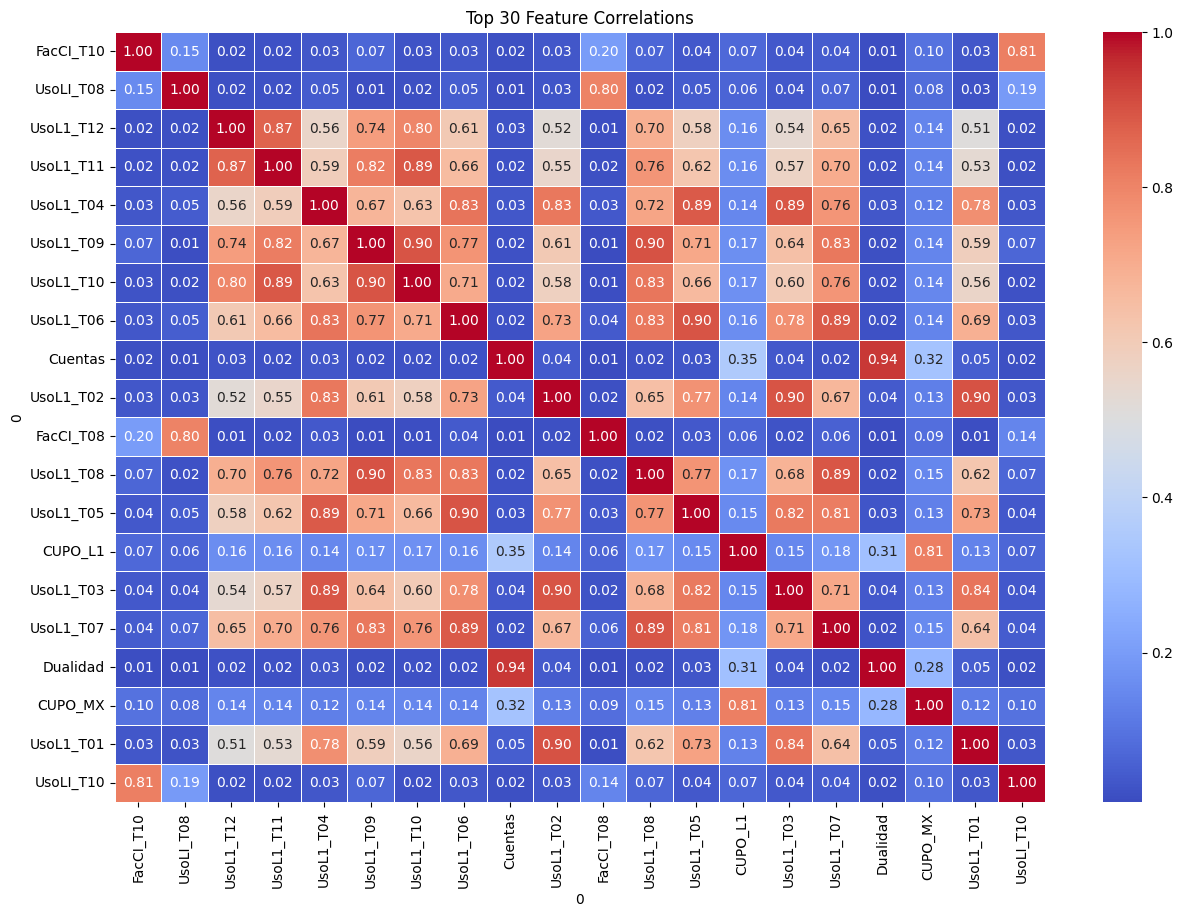

In [72]:
def plot_top_correlations(dataframe, top_n=30):
    # Calcular la matriz de correlación
    corr_matrix = dataframe.corr().abs()
    
    # Extraer las correlaciones superiores a la diagonal
    triangulo_matriz = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Encontrar las correlaciones más altas
    top_corr_pairs = (
        triangulo_matriz.unstack()
        .dropna()
        .sort_values(ascending=False)
        .head(top_n)
    )
    
    # Obtener las columnas de las correlaciones más altas
    top_columnas = list(set([index[0] for index in top_corr_pairs.index] + [index[1] for index in top_corr_pairs.index]))
    
    # Crear un nuevo dataframe con solo las columnas seleccionadas
    top_corr_dataframe = dataframe[top_columnas]
    
    # Calcular la matriz de correlación del nuevo dataframe
    top_corr_matriz = top_corr_dataframe.corr()
    
    # Dibujar el mapa de calor
    plt.figure(figsize=(15, 10))
    sb.heatmap(top_corr_matriz, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Top {} Feature Correlations'.format(top_n))
    plt.show()

# Uso de la función
# Asegúrate de reemplazar 'your_dataframe' con el nombre de tu dataframe
plot_top_correlations(df_acotado_numericas)


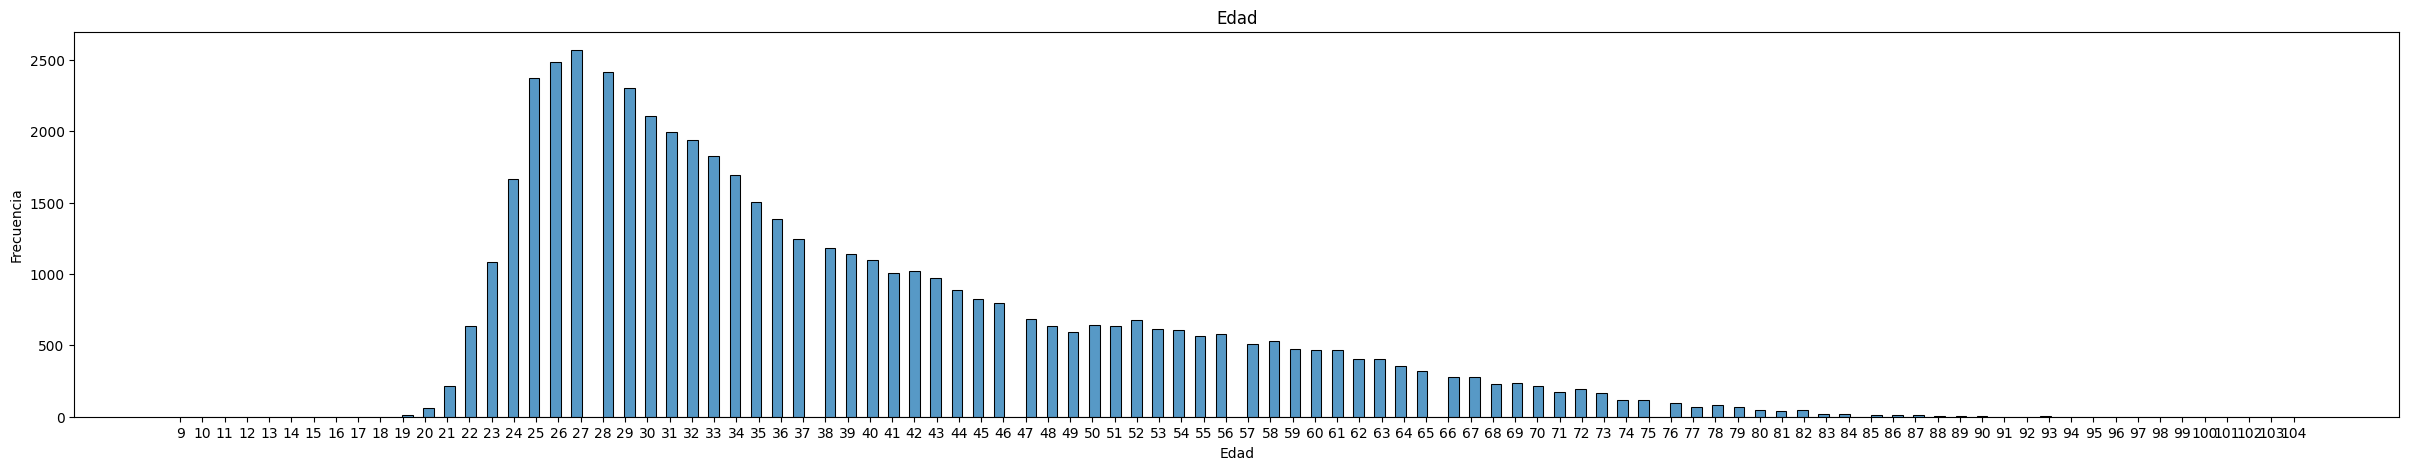

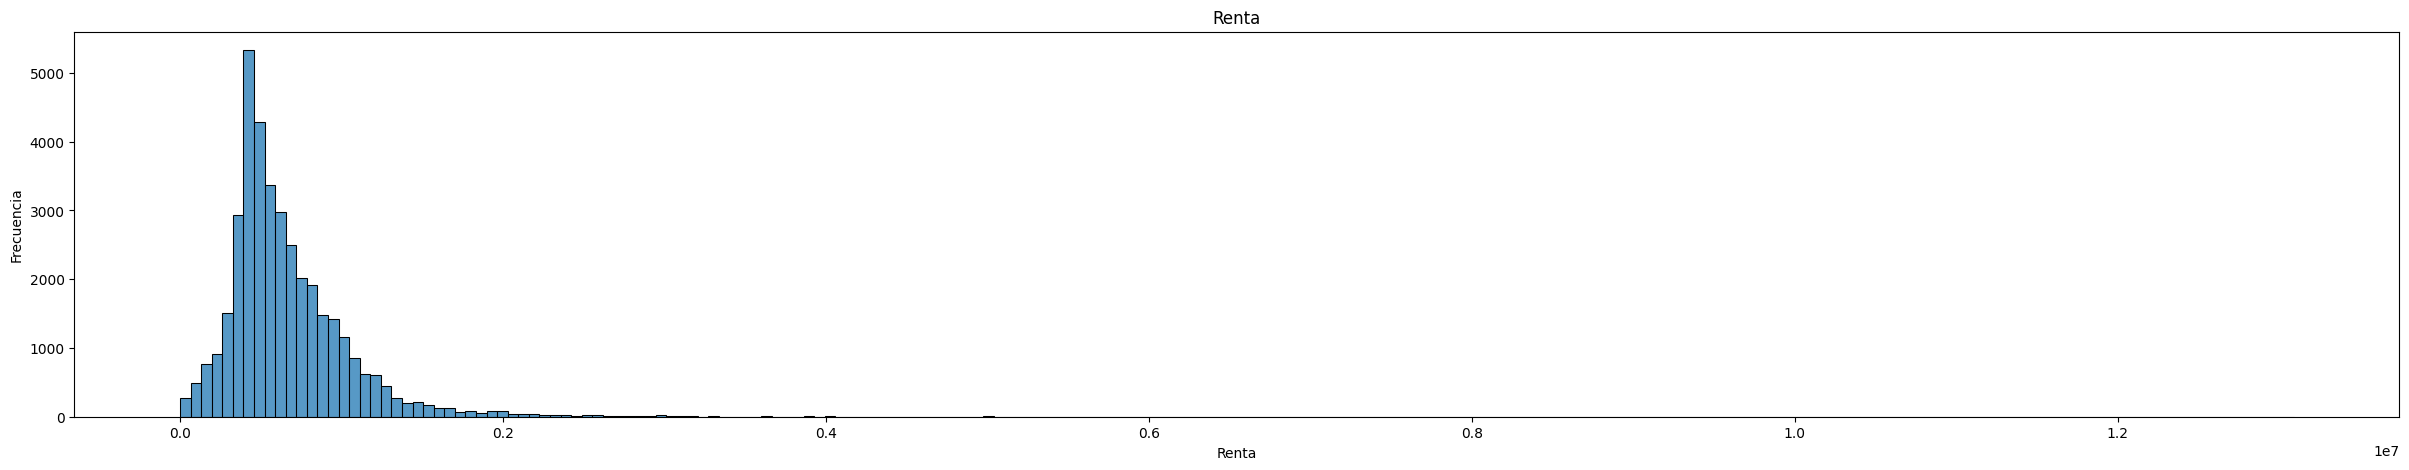

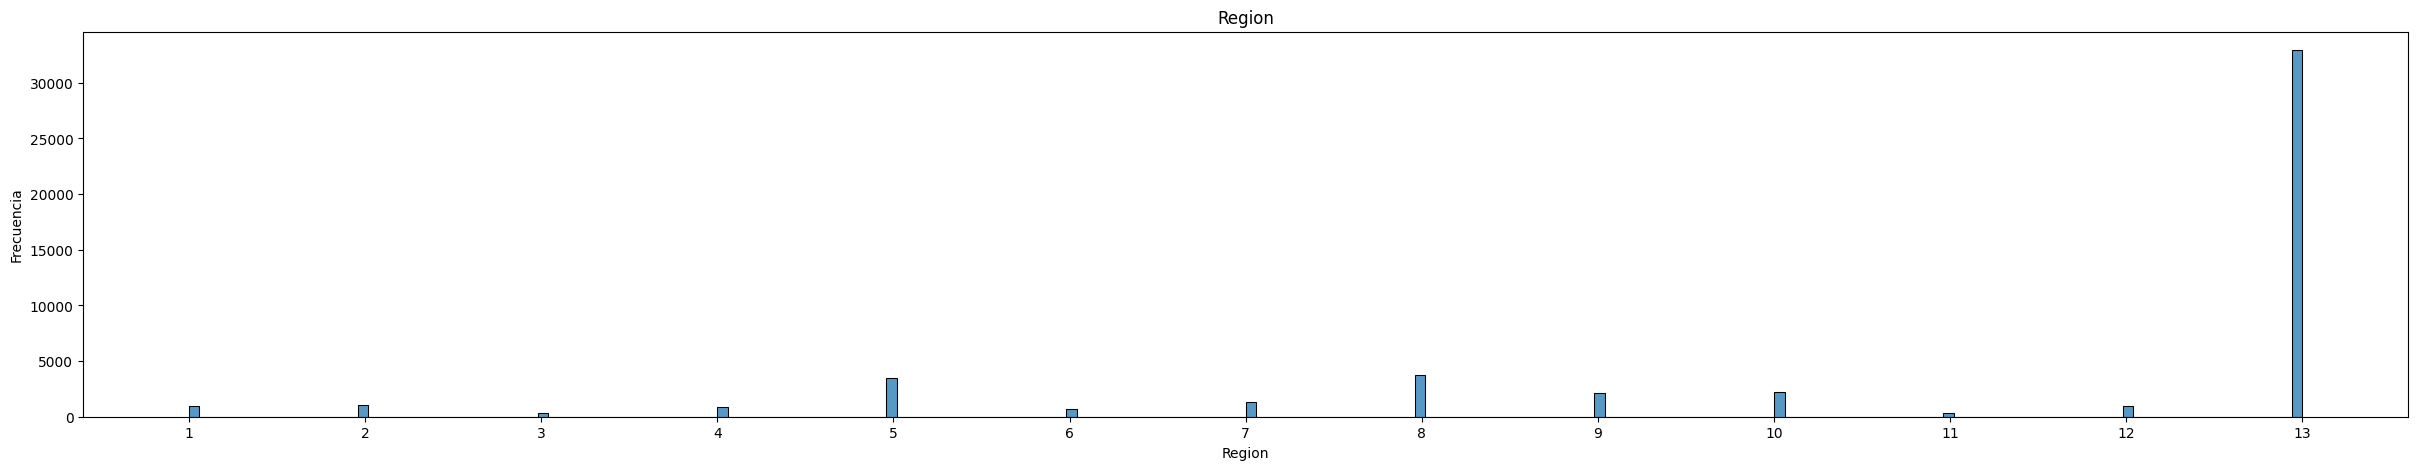

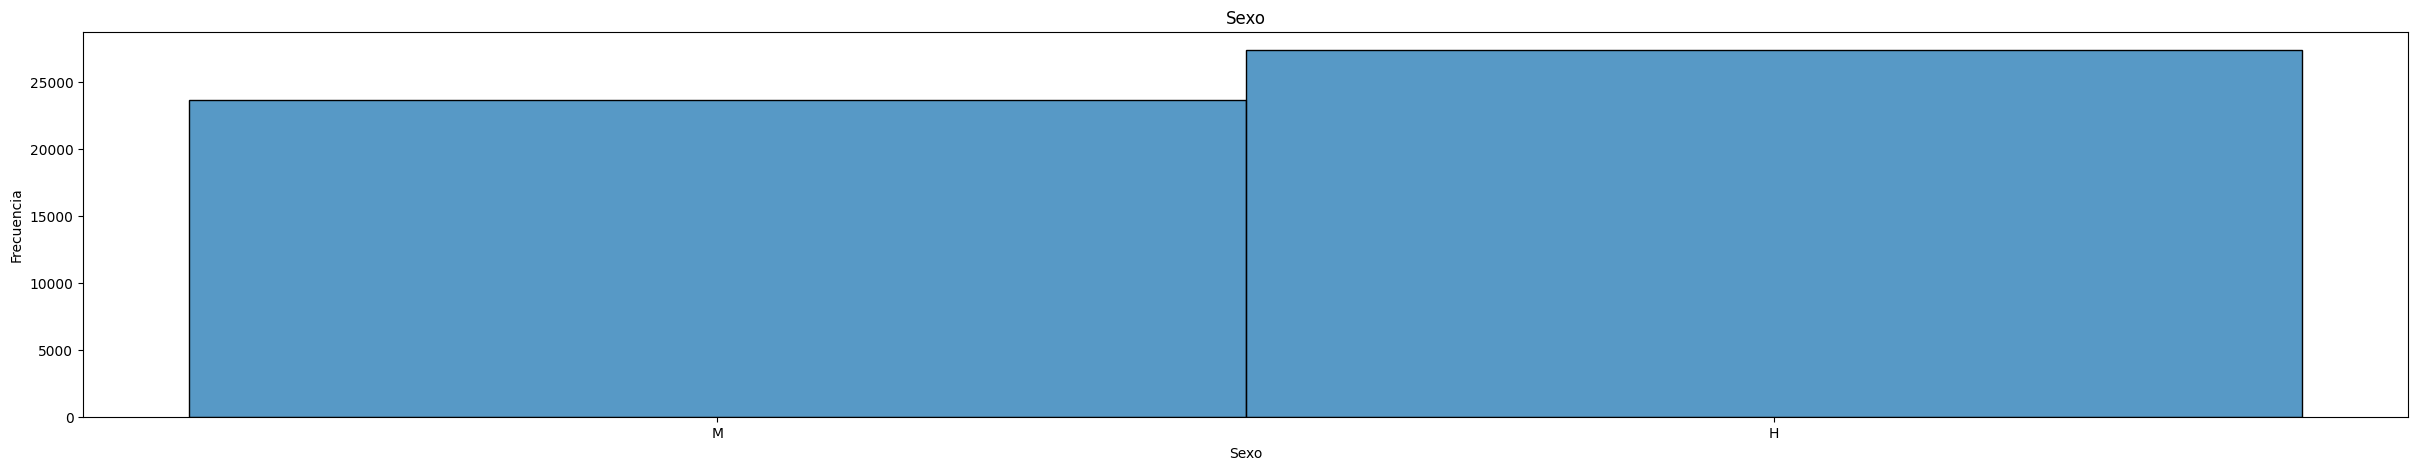

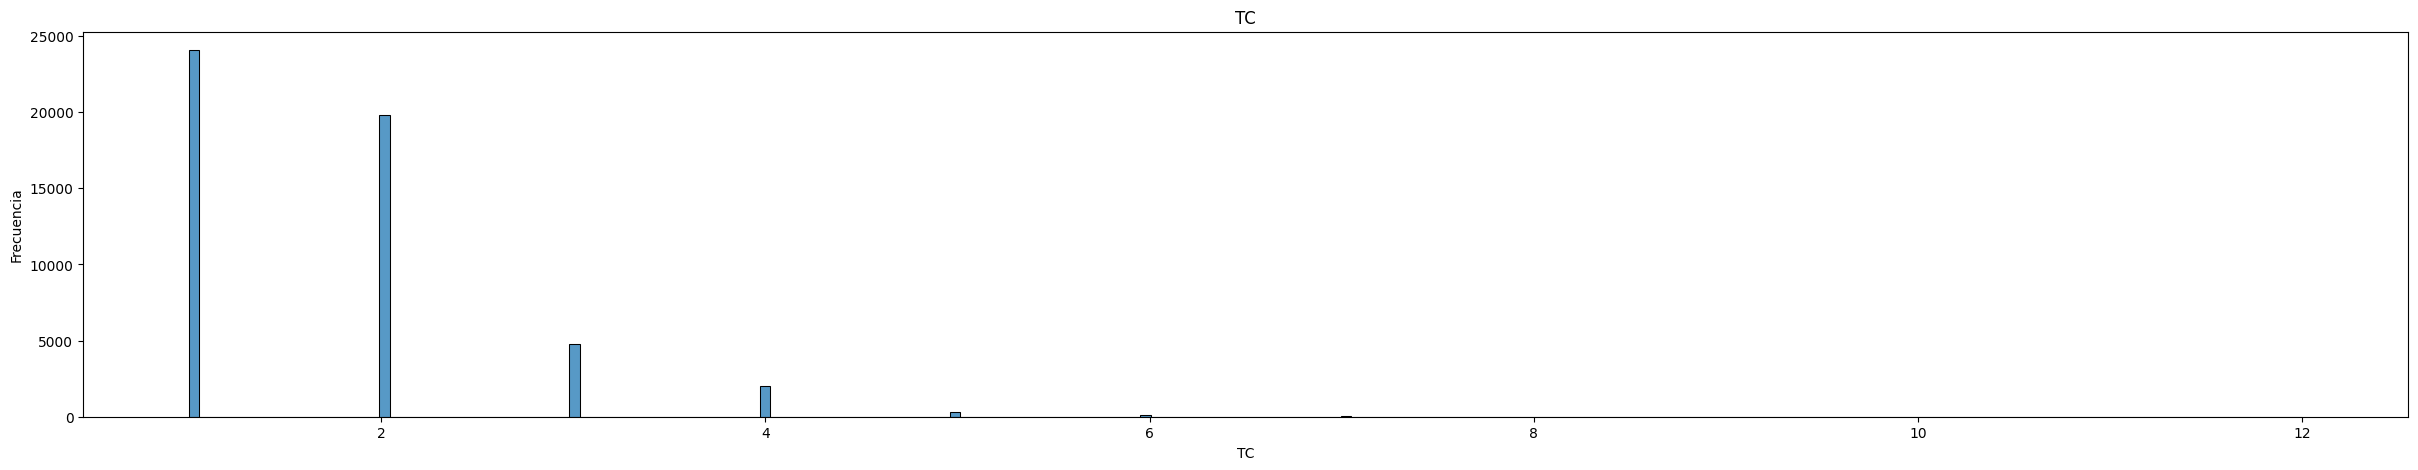

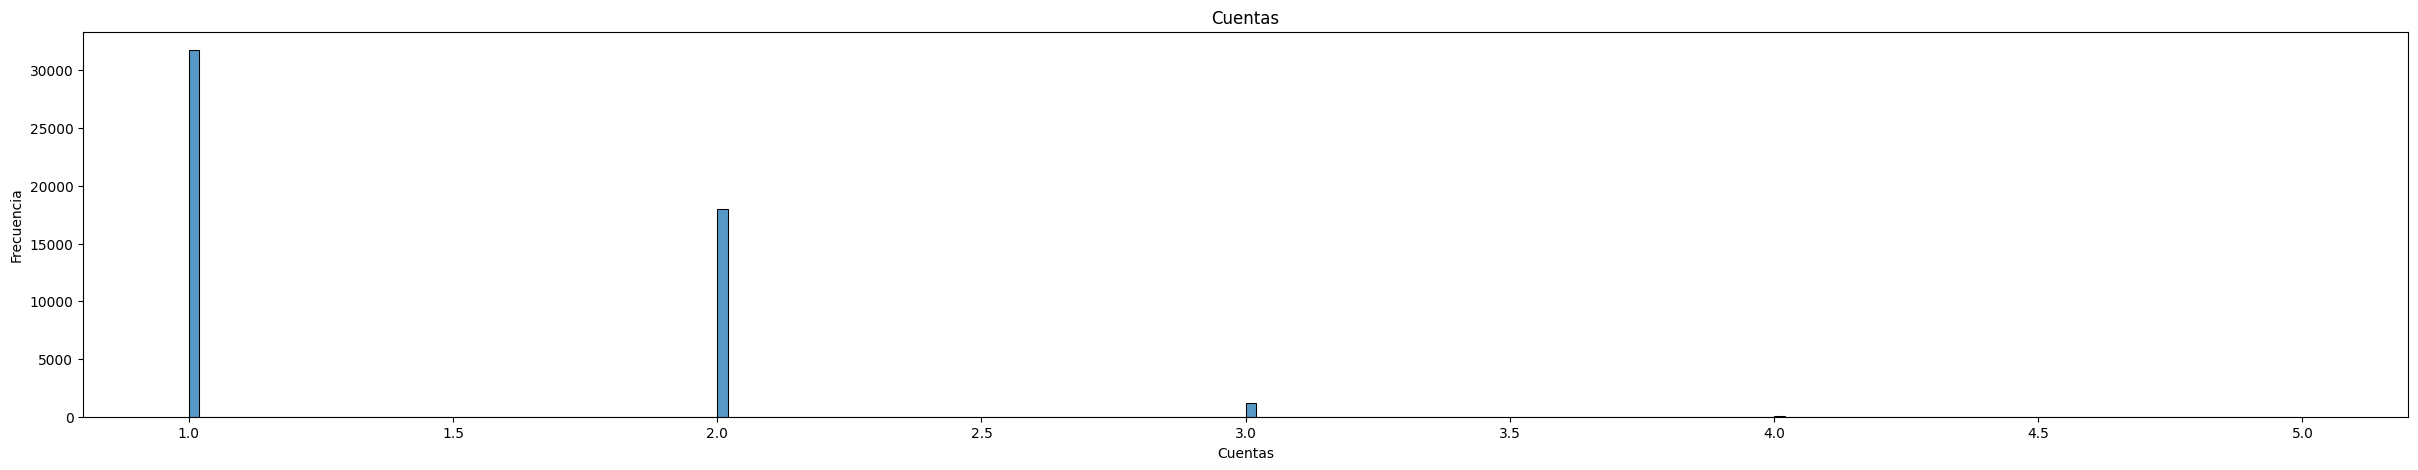

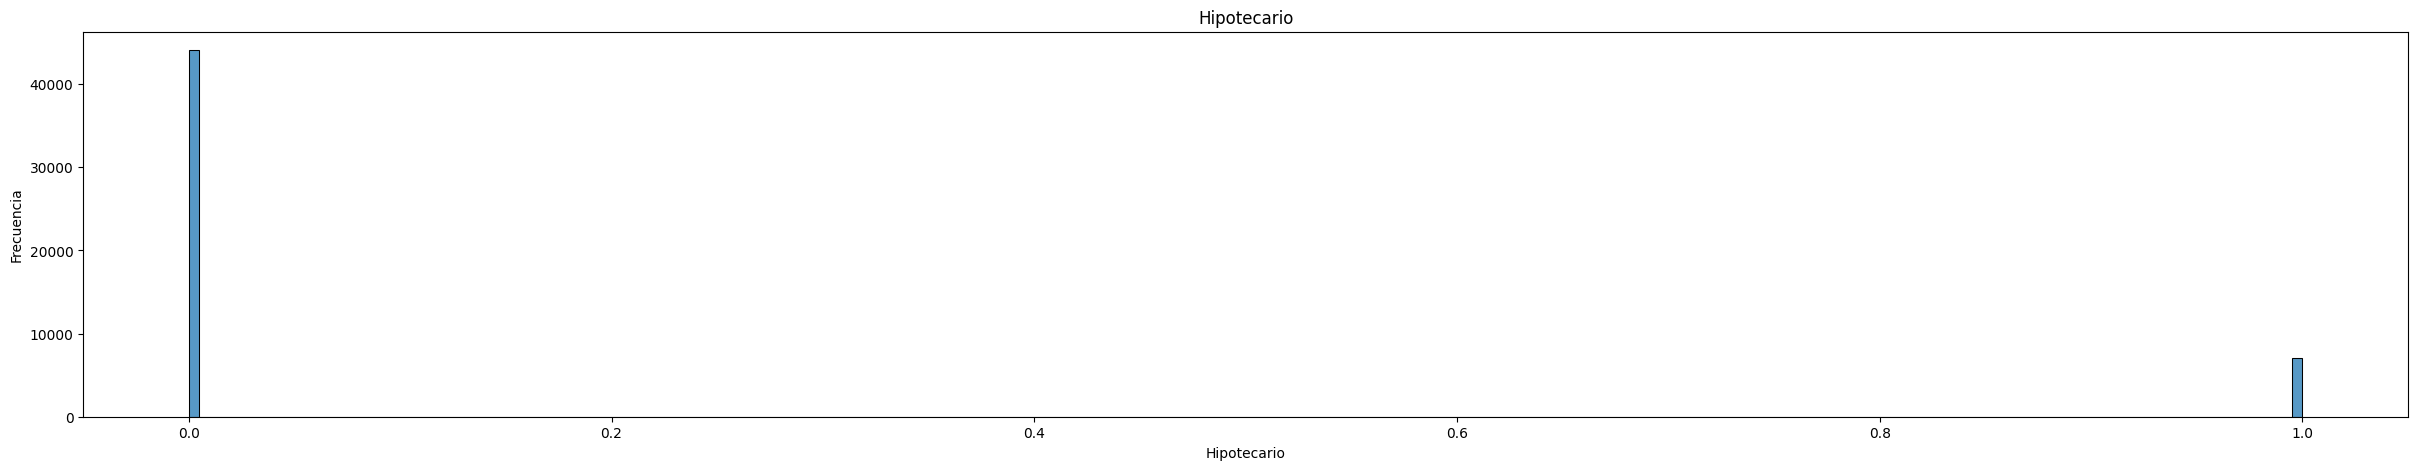

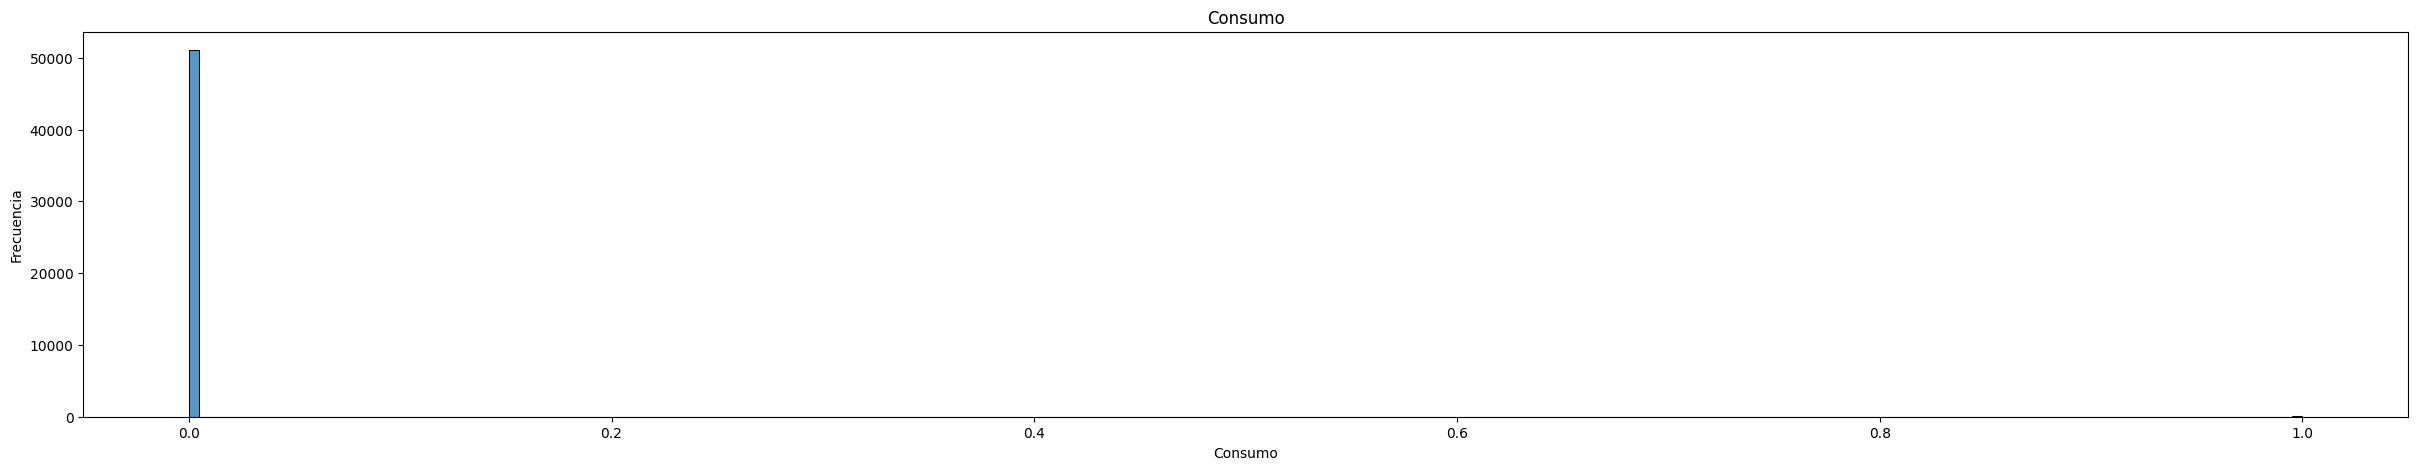

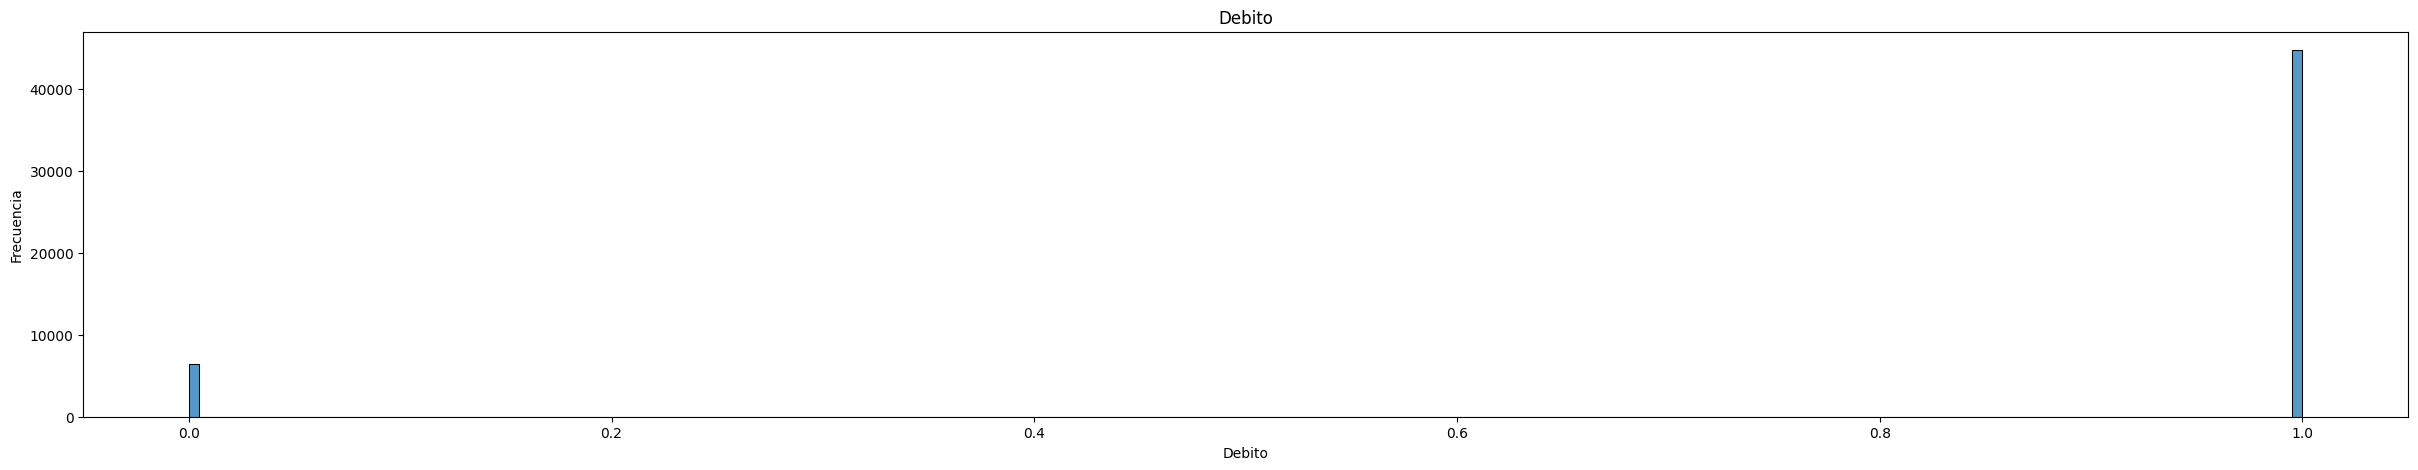

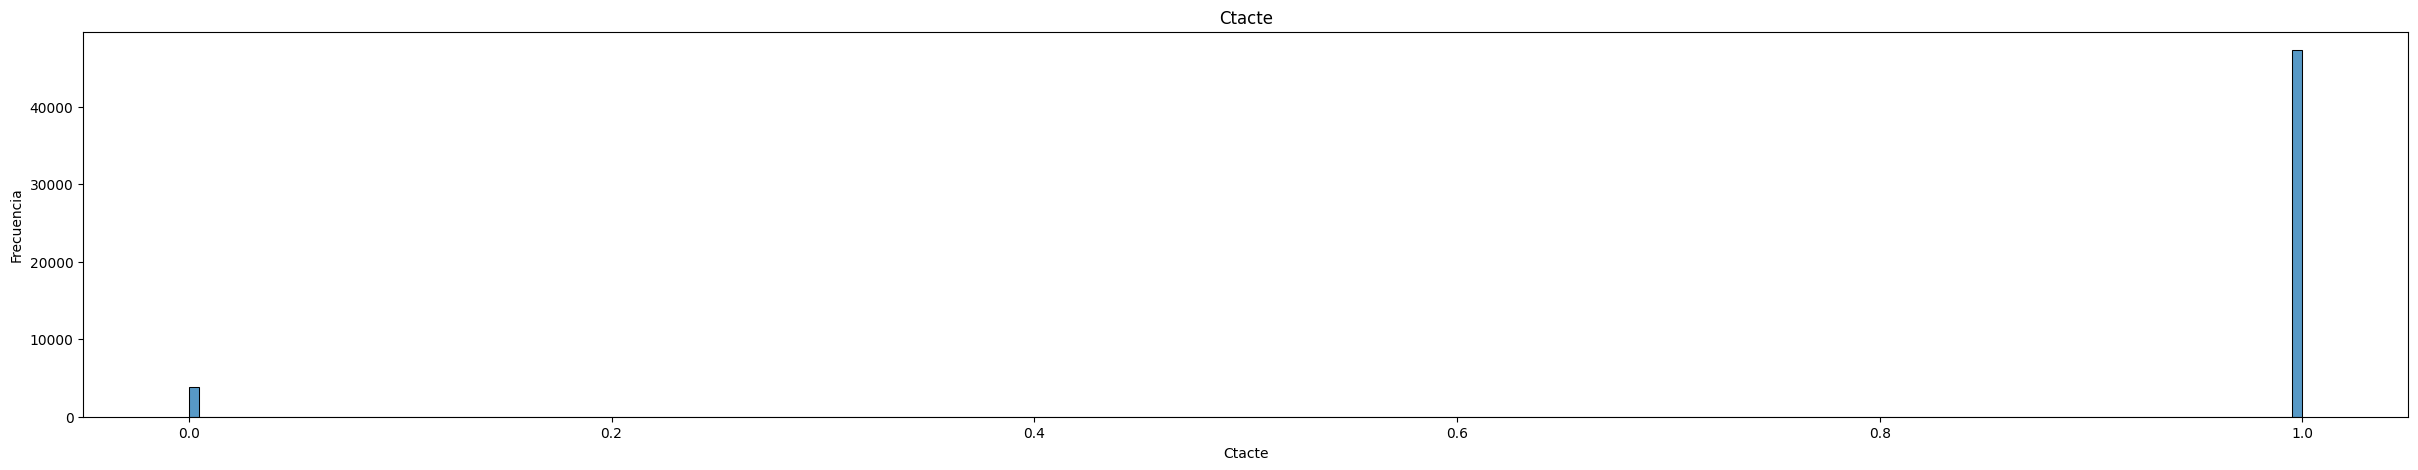

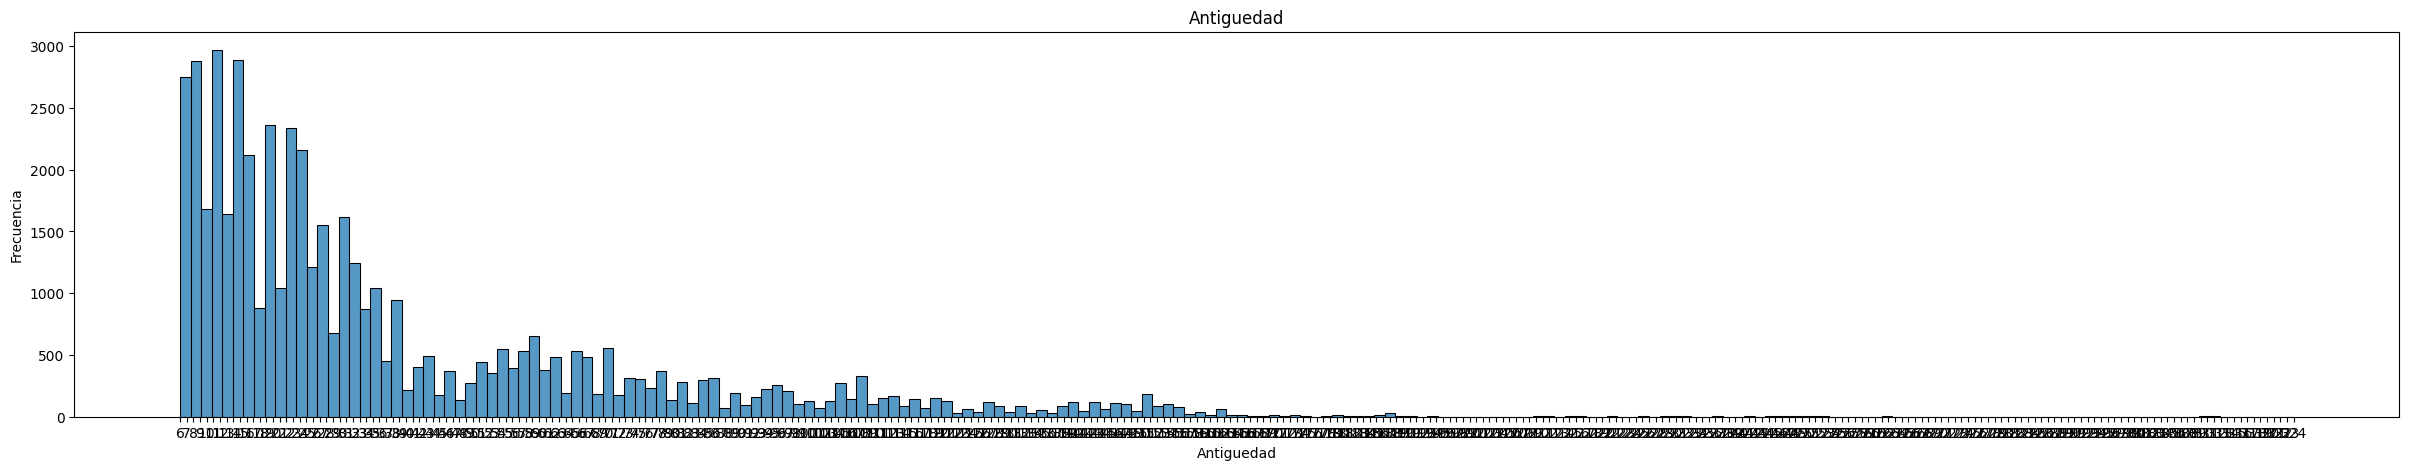

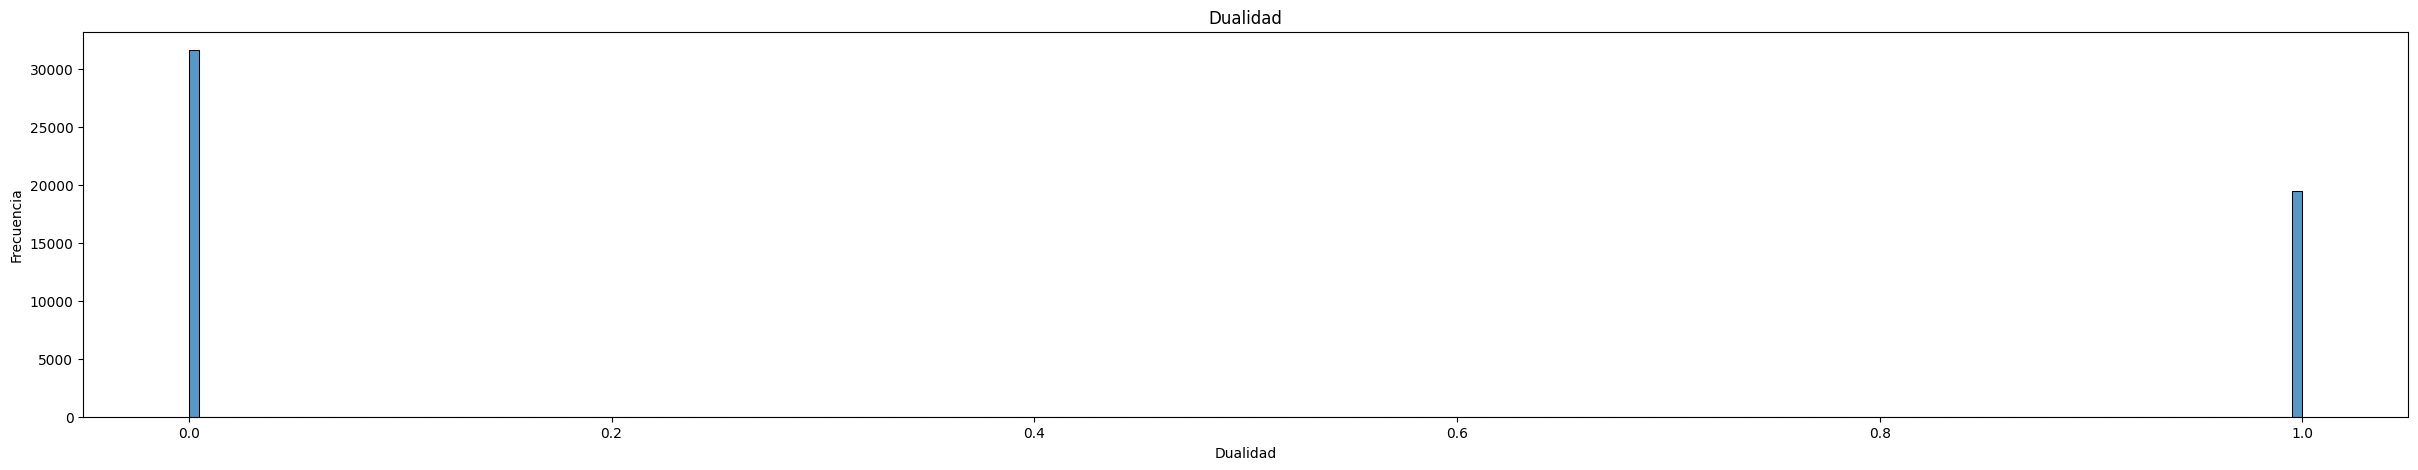

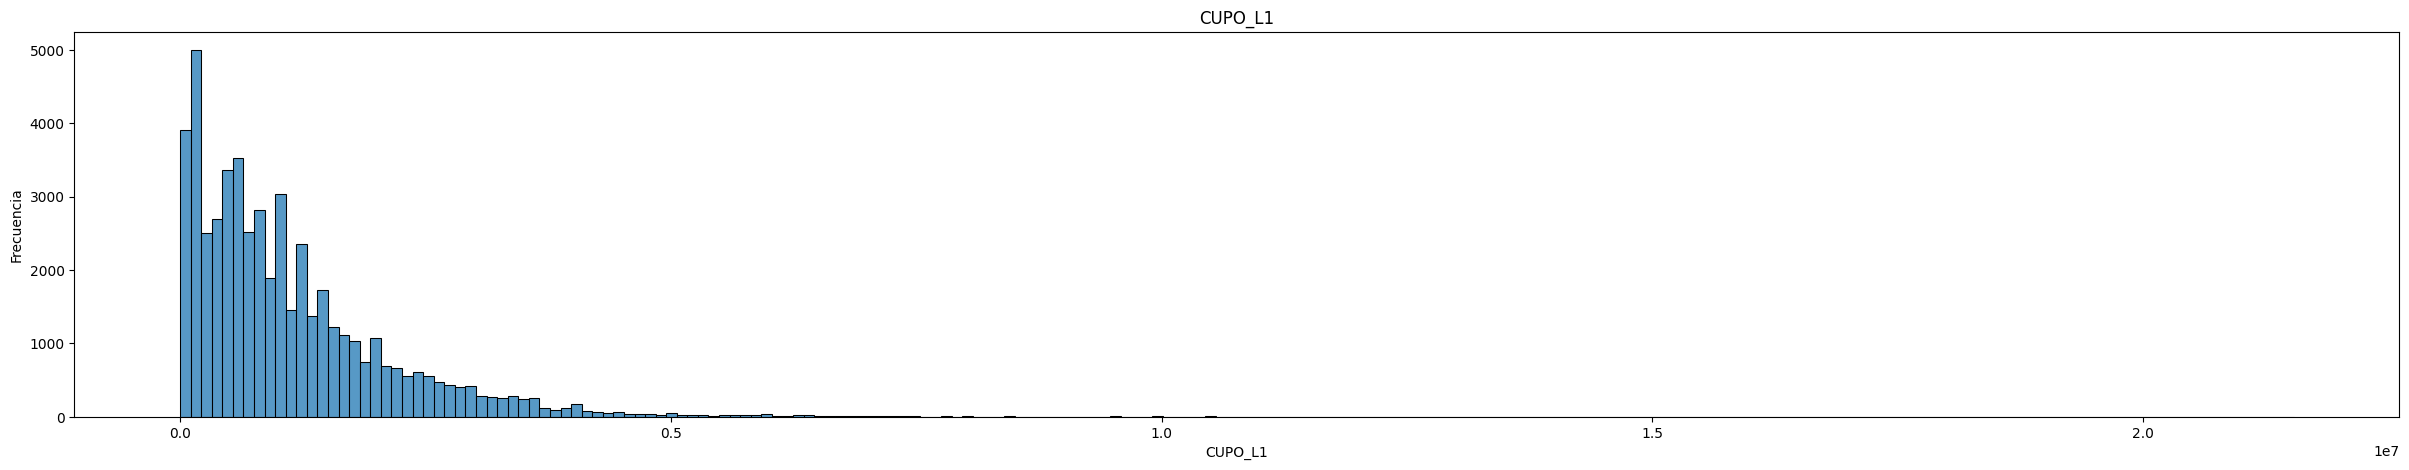

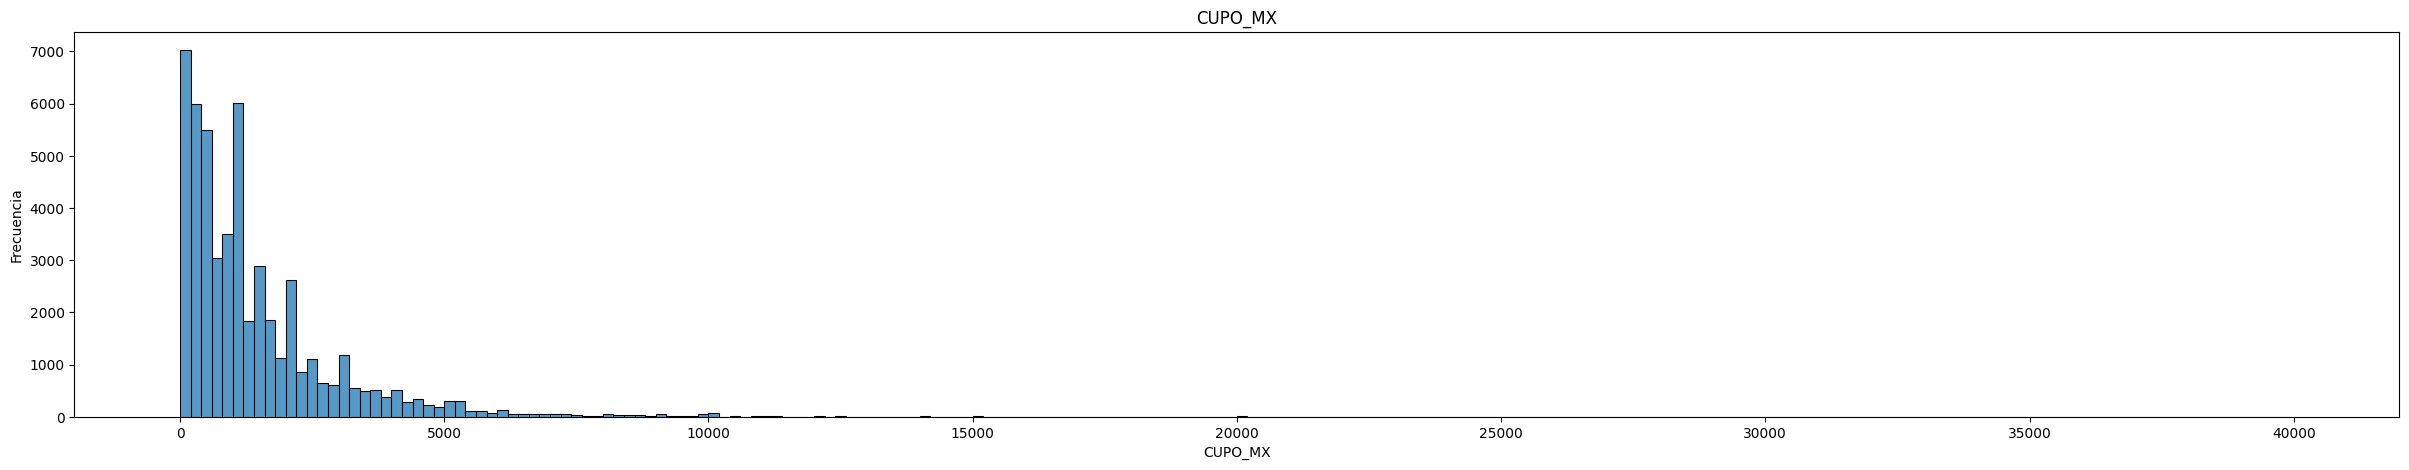

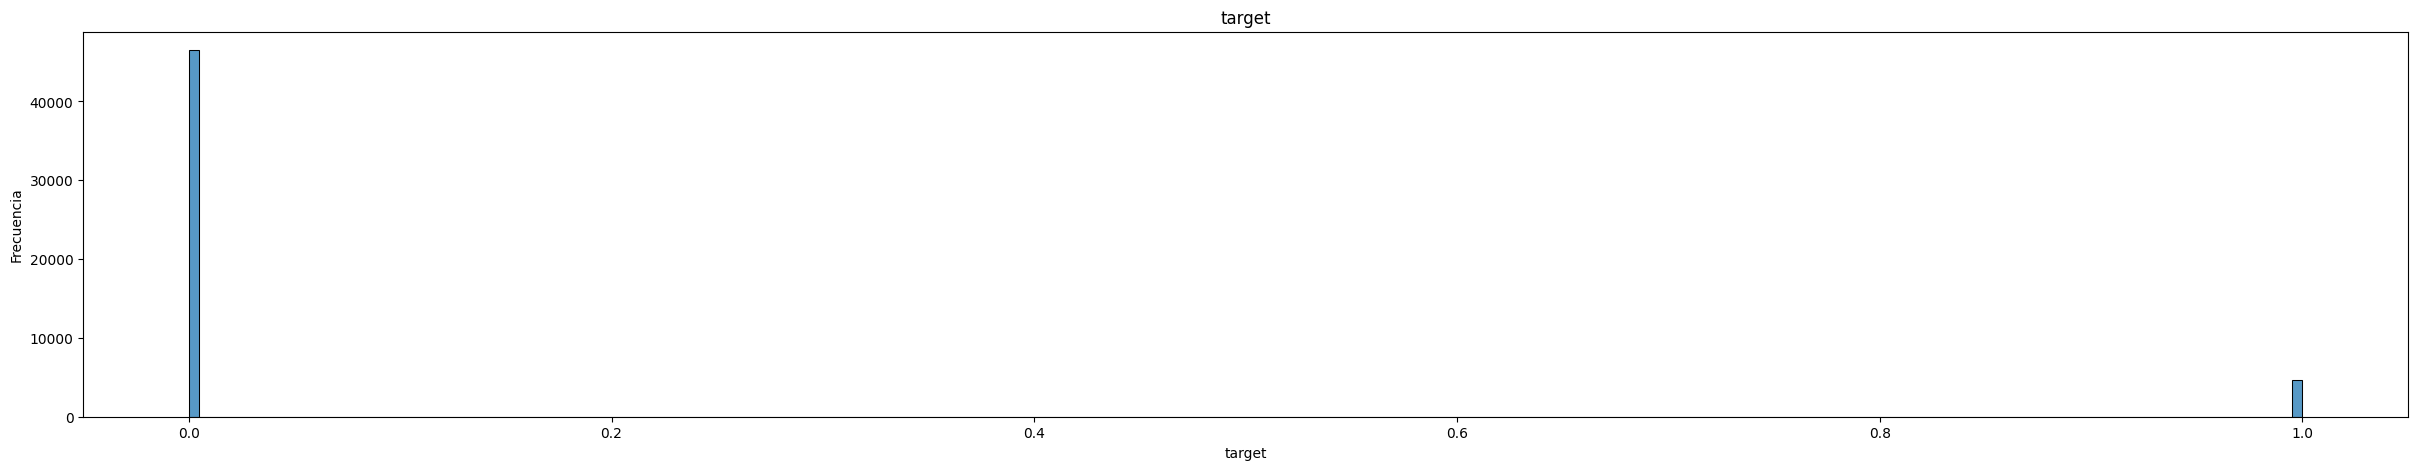

In [73]:
# Definimos las columnas que queremos analizar en detalle
columnas_para_filtrar = ['Edad', 'Region', 'Antiguedad']

# Iteramos sobre cada columna del DataFrame, excluyendo un gran conjunto de columnas
for columna in df_acotado.drop(df_acotado[['Id','FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 
              'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 
              'FacCN_T12', 'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 
              'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12', 'TxsCN_T01', 
              'TxsCN_T02', 'TxsCN_T03', 'TxsCN_T04', 'TxsCN_T05', 'TxsCN_T06', 'TxsCN_T07', 'TxsCN_T08', 
              'TxsCN_T09', 'TxsCN_T10', 'TxsCN_T11', 'TxsCN_T12', 'TxsCI_T01', 'TxsCI_T02', 'TxsCI_T03', 
              'TxsCI_T04', 'TxsCI_T05', 'TxsCI_T06', 'TxsCI_T07', 'TxsCI_T08', 'TxsCI_T09', 'TxsCI_T10', 
              'TxsCI_T11', 'TxsCI_T12', 'UsoL1_T01','UsoL1_T02', 'UsoL1_T03', 'UsoL1_T04', 'UsoL1_T05', 
              'UsoL1_T06', 'UsoL1_T07', 'UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10', 'UsoL1_T11', 'UsoL1_T12', 
              'UsoLI_T01', 'UsoLI_T02', 'UsoLI_T03', 'UsoLI_T04', 'UsoLI_T05', 'UsoLI_T06', 'UsoLI_T07', 
              'UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10', 'UsoLI_T11', 'UsoLI_T12', 
              'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 
              'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12', 
              'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 
              'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12', 
              'FlgAct_T01', 'FlgAct_T02', 'FlgAct_T03', 'FlgAct_T04', 'FlgAct_T05', 'FlgAct_T06', 'FlgAct_T07', 
              'FlgAct_T08', 'FlgAct_T09', 'FlgAct_T10', 'FlgAct_T11', 'FlgAct_T12', 'FacAN_T01', 'FacAN_T02', 
              'FacAN_T03', 'FacAN_T04', 'FacAN_T05', 'FacAN_T06', 'FacAN_T07', 'FacAN_T08', 'FacAN_T09', 
              'FacAN_T10', 'FacAN_T11', 'FacAN_T12', 'FacAI_T01', 'FacAI_T02', 'FacAI_T03', 'FacAI_T04', 
              'FacAI_T05', 'FacAI_T06', 'FacAI_T07', 'FacAI_T08', 'FacAI_T09', 'FacAI_T10', 'FacAI_T11', 
              'FacAI_T12', 'IndRev_T12','IndRev_T11','IndRev_T10','IndRev_T09','IndRev_T08',
              'IndRev_T07','IndRev_T06','IndRev_T05','IndRev_T04','IndRev_T03','IndRev_T02','IndRev_T01']], axis=1):
    plt.figure(figsize=(30, 5))
    sb.histplot(df_acotado[columna], bins=200)
    plt.title(columna)
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

    # Si la columna está en la lista de columnas a filtrar, ajustamos los límites de los ejes x
    if columna in columnas_para_filtrar:
        valor_max = df_acotado[columna].max()
        valor_min = df_acotado[columna].min()
        plt.xticks(np.arange(valor_min, valor_max + 1, step=1))
        plt.show()

### Una vez visto los gráficos, ahora veremos la distribución de los datos, destacando los cuartiles, los valores extremos (outliers) y algunas estadísticas básicas que podremos ver de forma gráfica de tres características posiblemente importantes.

C:\Users\new11\AppData\Local\Temp\ipykernel_12772\1179865995.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=df_acotado[columna], palette='Set2')


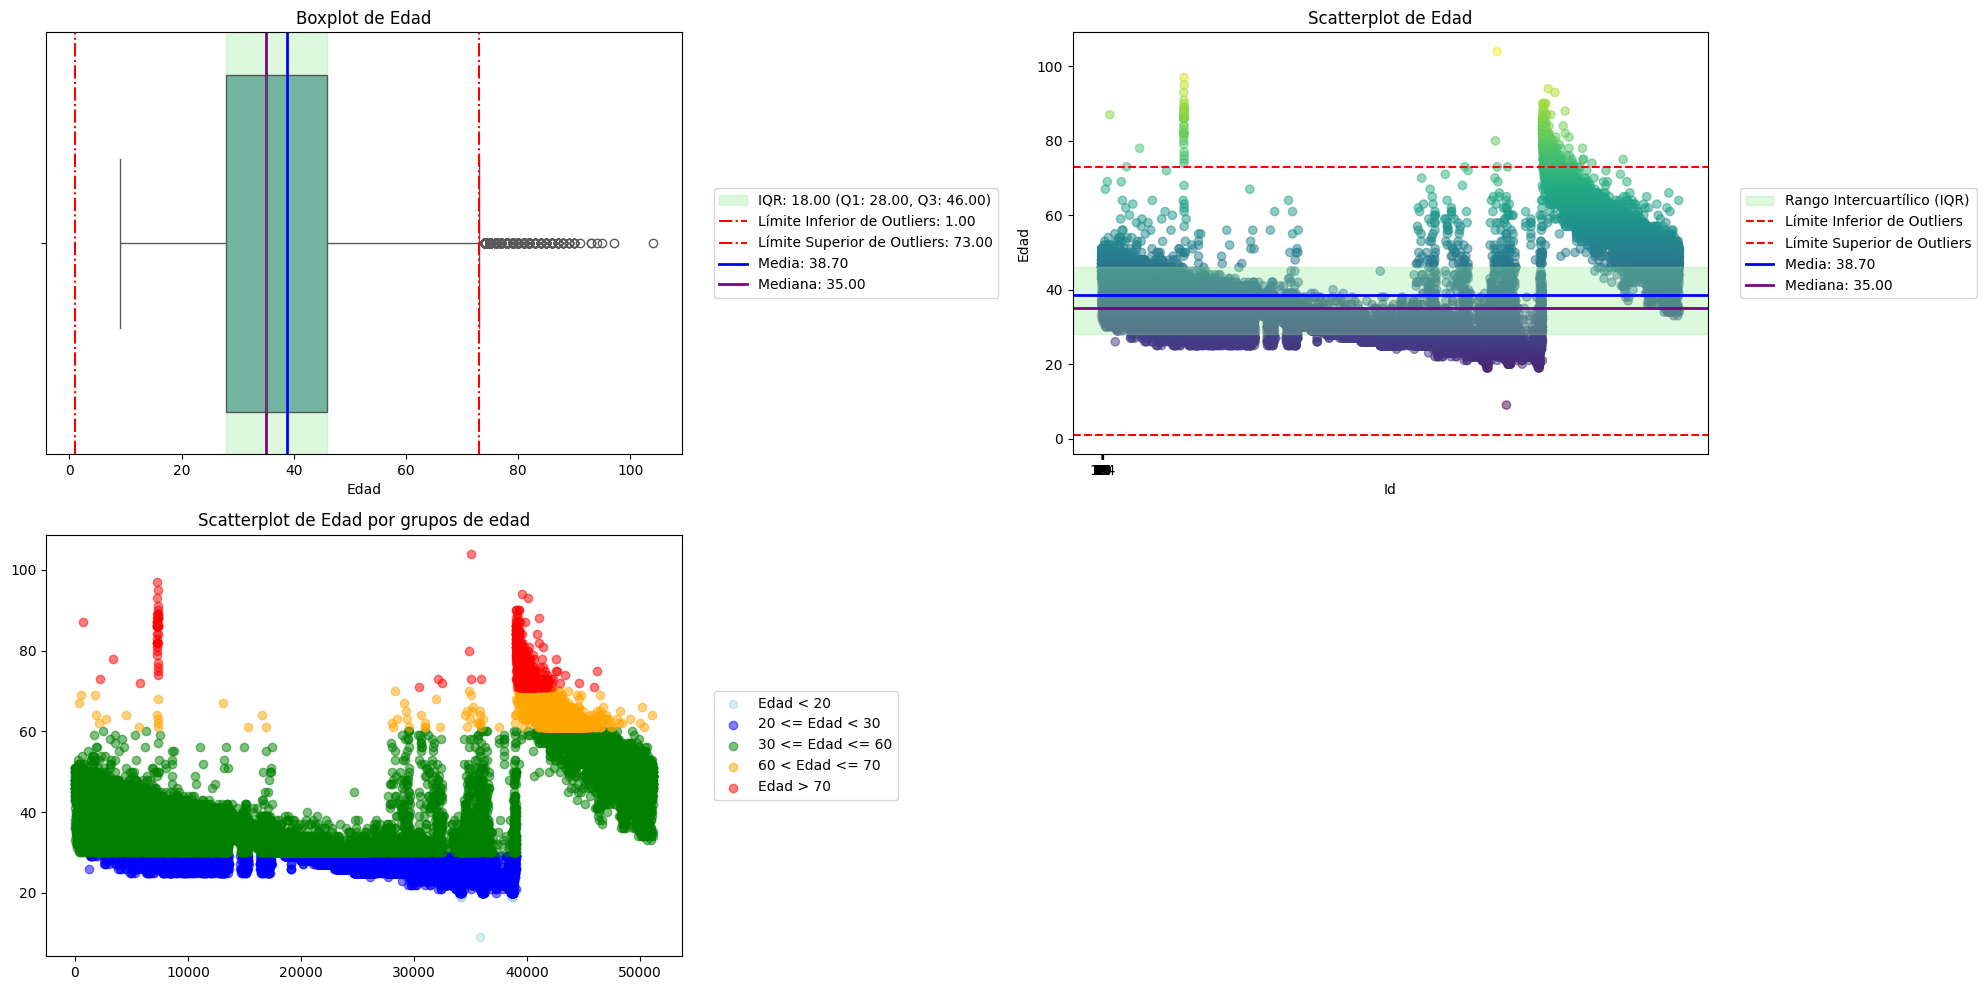

C:\Users\new11\AppData\Local\Temp\ipykernel_12772\1179865995.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=df_acotado[columna], palette='Set2')
C:\Users\new11\AppData\Local\Temp\ipykernel_12772\1179865995.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acotado['Region'] = df_acotado['Region'].fillna(0)  # Llenar NaN con 0 temporalmente


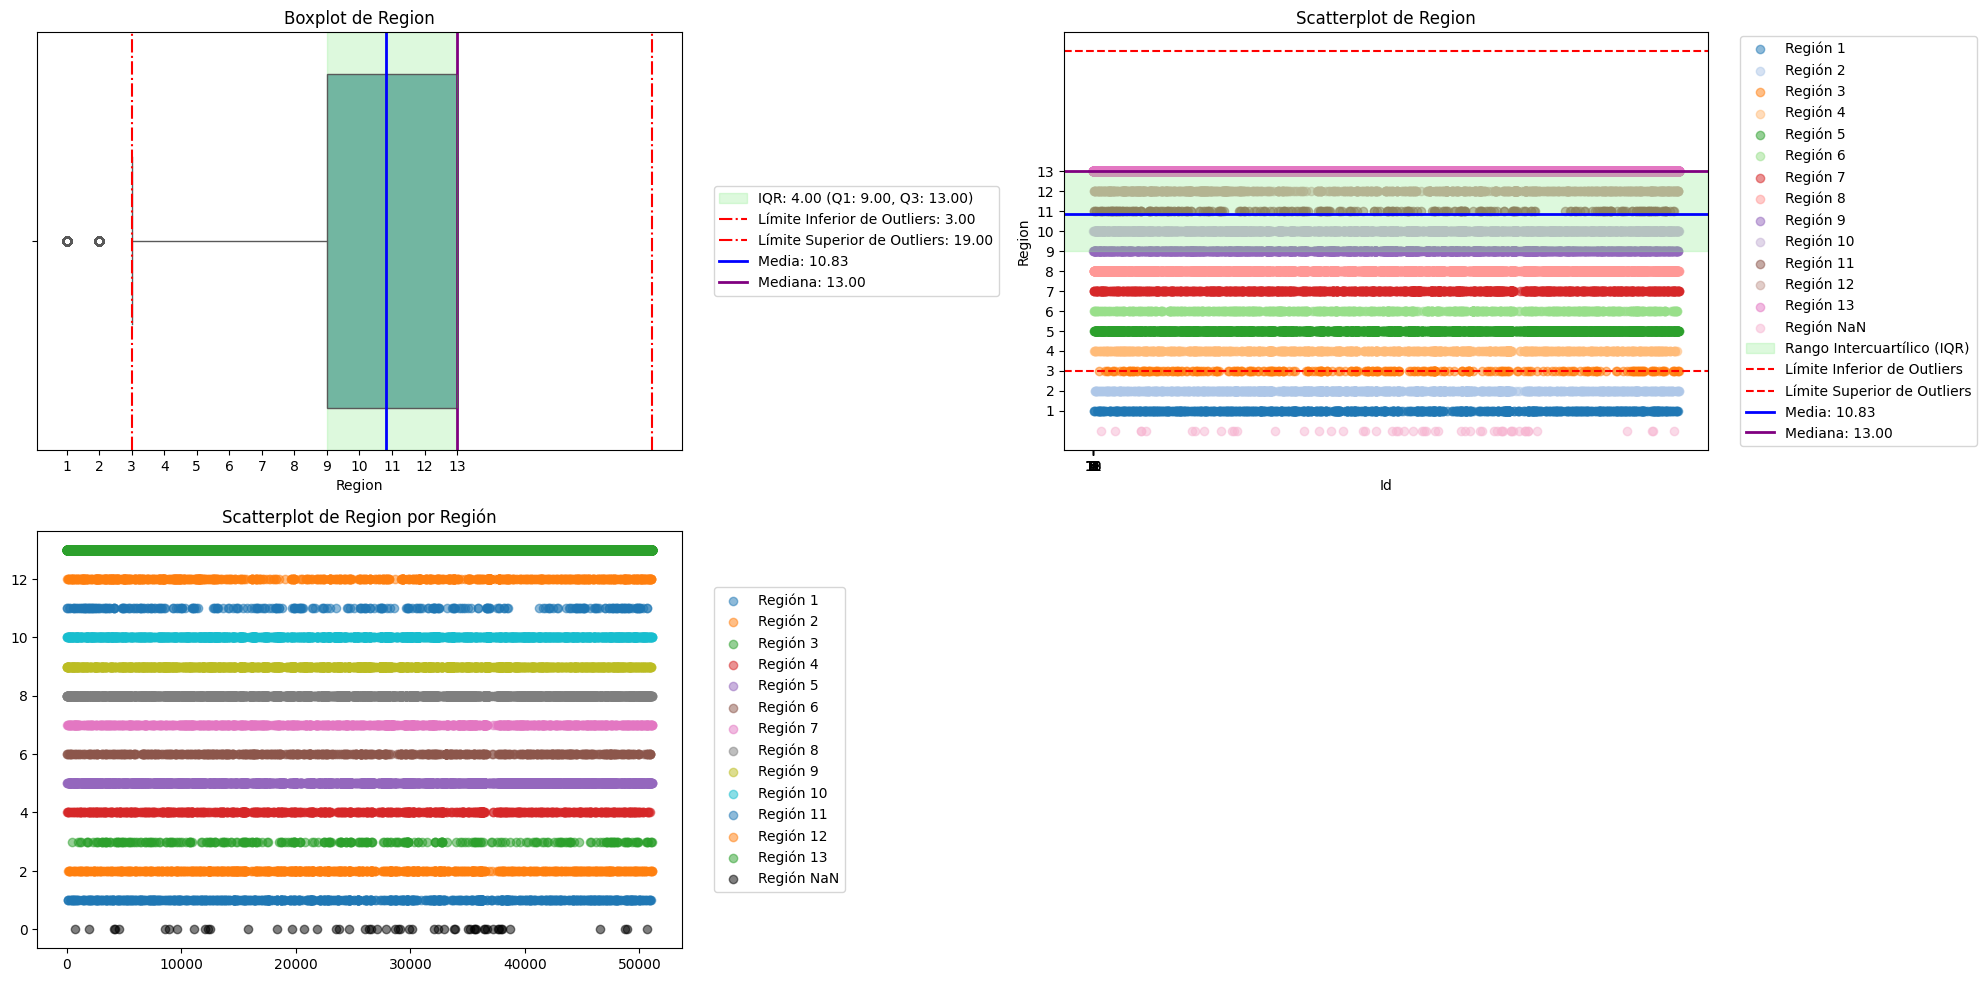

C:\Users\new11\AppData\Local\Temp\ipykernel_12772\1179865995.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=df_acotado[columna], palette='Set2')


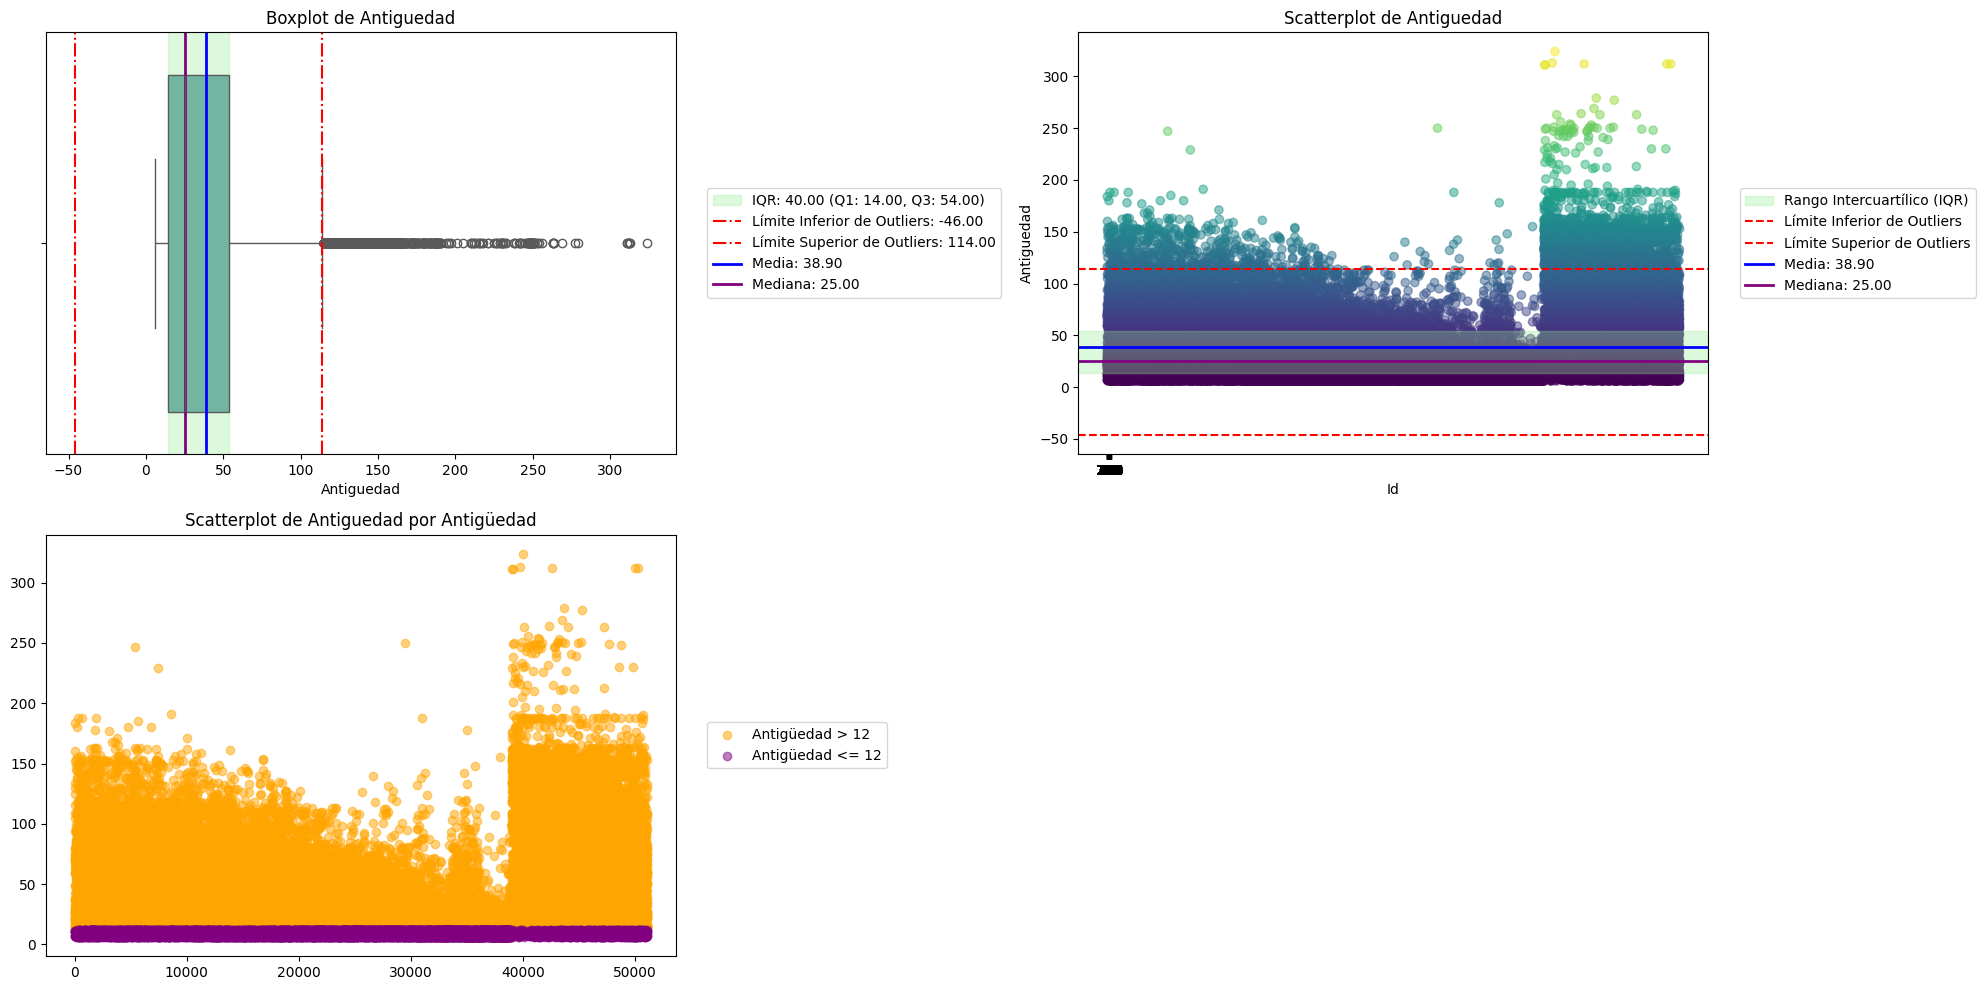

In [74]:
# Lista de columnas a analizar
columnas_a_analizar = ['Edad', 'Region', 'Antiguedad']

# Definir subconjuntos de edad en más rangos
df_sub_edad_menor_20 = df_acotado[df_acotado['Edad'] < 20]
df_sub_edad_joven = df_acotado[(df_acotado['Edad'] >= 20) & (df_acotado['Edad'] < 30)]
df_sub_edad_adulto = df_acotado[(df_acotado['Edad'] >= 30) & (df_acotado['Edad'] <= 60)]
df_sub_edad_mayor = df_acotado[(df_acotado['Edad'] > 60) & (df_acotado['Edad'] <= 70)]
df_sub_edad_mayor_70 = df_acotado[df_acotado['Edad'] > 70]

# Transparencia para los scatterplots
alpha_value = 0.5

# Contar el número de regiones únicas, incluyendo NaN
num_regiones = df_acotado['Region'].nunique()

# Mapa de colores personalizado para las regiones, incluyendo NaN
colores_regiones = sb.color_palette("tab20", num_regiones + 1)  # Incluye un color para NaN

for columna in columnas_a_analizar:
    plt.figure(figsize=(20, 10))
    
    # Cálculo de la media y mediana
    media = df_acotado[columna].mean()
    mediana = df_acotado[columna].median()

    # Cálculo del rango intercuartílico (IQR)
    Q1 = df_acotado[columna].quantile(0.25)
    Q3 = df_acotado[columna].quantile(0.75)
    IQR = Q3 - Q1
    lim_inferior = Q1 - 1.5 * IQR
    lim_superior = Q3 + 1.5 * IQR
    
    # Boxplot con IQR destacado
    plt.subplot(2, 2, 1)
    sb.boxplot(x=df_acotado[columna], palette='Set2')

    # Resaltar el IQR en el boxplot
    plt.axvspan(Q1, Q3, color='lightgreen', alpha=0.3, label=f'IQR: {IQR:.2f} (Q1: {Q1:.2f}, Q3: {Q3:.2f})')
    
    # Líneas para los límites de los outliers
    plt.axvline(lim_inferior, color='red', linestyle='dashdot', label=f'Límite Inferior de Outliers: {lim_inferior:.2f}')
    plt.axvline(lim_superior, color='red', linestyle='dashdot', label=f'Límite Superior de Outliers: {lim_superior:.2f}')
    
    # Líneas para la media y mediana
    plt.axvline(media, color='blue', linestyle='-', label=f'Media: {media:.2f}', linewidth=2)
    plt.axvline(mediana, color='purple', linestyle='-', label=f'Mediana: {mediana:.2f}', linewidth=2)

    # Asegurarse de que los ticks en el eje X sean enteros (solo para la columna Región)
    if columna == 'Region':
        plt.xticks(np.arange(1, num_regiones + 1, step=1), [str(i) for i in range(1, num_regiones + 1)])
    
    plt.title(f'Boxplot de {columna}')
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico
    
    # Scatterplot con transparencia y coloración por valores (Regiones ordenadas)
    plt.subplot(2, 2, 2)
    
    if columna == 'Region':
        # Ordenar las regiones y asignar colores
        df_acotado['Region'] = df_acotado['Region'].fillna(0)  # Llenar NaN con 0 temporalmente
        regiones_ordenadas = np.sort(df_acotado['Region'].unique())  # Ordenar las regiones numéricamente, NaN quedará en 0

        # Separar la etiqueta para Región NaN
        regiones_ordenadas = regiones_ordenadas[regiones_ordenadas != 0]  # Excluir temporalmente Región 0 (NaN)
        regiones_ordenadas = np.append(regiones_ordenadas, 0)  # Añadir Región 0 (NaN) al final

        for idx, region in enumerate(regiones_ordenadas):
            if region == 0:
                label = 'Región NaN'  # Etiqueta para NaN
            else:
                label = f'Región {int(region)}'  # Etiquetas para las regiones numéricas
            
            df_region = df_acotado[df_acotado['Region'] == region]
            plt.scatter(df_region['Id'], df_region['Region'], alpha=alpha_value, label=label, c=[colores_regiones[idx]])

        # Ajustar el eje Y para que muestre los números enteros del 1 al 13
        plt.yticks(np.arange(1, 14, step=1), [str(i) for i in range(1, 14)])
        plt.xticks(np.arange(0, df_acotado['Id'].max(), step=10000))  # Asegura que las regiones se muestren adecuadamente
    else:
        plt.scatter(df_acotado['Id'], df_acotado[columna], alpha=alpha_value, c=df_acotado[columna], cmap='viridis')

    # Resaltar IQR en el scatterplot
    plt.axhspan(Q1, Q3, color='lightgreen', alpha=0.3, label='Rango Intercuartílico (IQR)')
    plt.axhline(lim_inferior, color='red', linestyle='--', label='Límite Inferior de Outliers')
    plt.axhline(lim_superior, color='red', linestyle='--', label='Límite Superior de Outliers')

    # Líneas para la media y mediana en el scatterplot
    plt.axhline(media, color='blue', linestyle='-', label=f'Media: {media:.2f}', linewidth=2)
    plt.axhline(mediana, color='purple', linestyle='-', label=f'Mediana: {mediana:.2f}', linewidth=2)
    
    plt.title(f'Scatterplot de {columna}')
    plt.xlabel('Id')
    plt.ylabel(columna)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico

    # Añadir más ticks en el eje X para columnas específicas
    if columna == 'Edad':
        plt.xticks(np.arange(df_acotado['Edad'].min(), df_acotado['Edad'].max() + 1, step=5))
    elif columna == 'Region':
        plt.xticks(np.arange(1, num_regiones + 1, step=1))  # Mostrar regiones del 1 a num_regiones
    elif columna == 'Antiguedad':
        plt.xticks(np.arange(df_acotado['Antiguedad'].min(), df_acotado['Antiguedad'].max() + 1, step=2))

    # Scatterplot con subconjuntos por grupos de edad, añadiendo nuevos rangos
    plt.subplot(2, 2, 3)
    if columna == 'Edad':
        plt.scatter(df_sub_edad_menor_20['Id'], df_sub_edad_menor_20[columna], alpha=alpha_value, label='Edad < 20', c='lightblue')
        plt.scatter(df_sub_edad_joven['Id'], df_sub_edad_joven[columna], alpha=alpha_value, label='20 <= Edad < 30', c='blue')
        plt.scatter(df_sub_edad_adulto['Id'], df_sub_edad_adulto[columna], alpha=alpha_value, label='30 <= Edad <= 60', c='green')
        plt.scatter(df_sub_edad_mayor['Id'], df_sub_edad_mayor[columna], alpha=alpha_value, label='60 < Edad <= 70', c='orange')
        plt.scatter(df_sub_edad_mayor_70['Id'], df_sub_edad_mayor_70[columna], alpha=alpha_value, label='Edad > 70', c='red')
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico
        plt.title(f'Scatterplot de {columna} por grupos de edad')

    elif columna == 'Region':
        # Scatterplot con valores NaN en negro
        for region in regiones_ordenadas:
            if region == 0:
                df_region_nan = df_acotado[df_acotado['Region'] == 0]  # Filtrar Región NaN
                plt.scatter(df_region_nan['Id'], df_region_nan['Region'], alpha=alpha_value, label='Región NaN', c='black')
            else:
                df_region = df_acotado[df_acotado['Region'] == region]
                plt.scatter(df_region['Id'], df_region[columna], alpha=alpha_value, label=f'Región {int(region)}')

        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico
        plt.title(f'Scatterplot de {columna} por Región')

    elif columna == 'Antiguedad':
        # Subconjuntos de antigüedad
        df_sub_antiguo = df_acotado[df_acotado['Antiguedad'] > 12]
        df_sub_nuevo = df_acotado[df_acotado['Antiguedad'] <= 12]
        plt.scatter(df_sub_antiguo['Id'], df_sub_antiguo[columna], alpha=alpha_value, label='Antigüedad > 12', c='orange')
        plt.scatter(df_sub_nuevo['Id'], df_sub_nuevo[columna], alpha=alpha_value, label='Antigüedad <= 12', c='purple')
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico
        plt.title(f'Scatterplot de {columna} por Antigüedad')

    # Ajustar diseño para evitar solapamientos
    plt.tight_layout()  
    plt.show()

### A continuación revisaremos los datos de la columna Región para saber exactamente cómo se distribuyen los clientes a lo largo del país.

In [75]:
region = df_acotado['Region']
region.unique()

array([13.,  9., 10.,  8.,  7.,  6.,  5., 12., 11.,  4.,  1.,  2.,  3.,
        0.])

### Revisamos un poco de estadística básica.

In [76]:
# Eliminar los valores NaN en la columna 'Region'
df_acotado['Region'].dropna(inplace=True)

# Eliminar los valores 0 de la columna 'Region'
df_acotado = df_acotado[df_acotado['Region'] != 0]

# Mostrar las estadísticas descriptivas de la columna 'Region'
print(df_acotado['Region'].describe())

# Mostrar los valores únicos en la columna 'Region'
print(df_acotado['Region'].unique())


count    51071.000000
mean        10.828220
std          3.392703
min          1.000000
25%          9.000000
50%         13.000000
75%         13.000000
max         13.000000
Name: Region, dtype: float64
[13.  9. 10.  8.  7.  6.  5. 12. 11.  4.  1.  2.  3.]


C:\Users\new11\AppData\Local\Temp\ipykernel_12772\2994265869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acotado['Region'].dropna(inplace=True)


### Verificamos que estamos tratando el número de la región como un dato entero.

In [77]:
region = df_acotado['Region']
region = region.astype(int)
region.unique()

array([13,  9, 10,  8,  7,  6,  5, 12, 11,  4,  1,  2,  3])

### Y seleccionados los rangos que se mostrarán en el gráfico.

In [78]:
# Los gráficos de torta contarán el número datos entre los rangos y lo mostraremos en un gráfico.
n1 = region.loc[region == 1].count()
n2 = region.loc[region == 2].count()
n3 = region.loc[region == 3].count()
n4 = region.loc[region == 4].count()
n5 = region.loc[region == 5].count()
n6 = region.loc[region == 6].count()
n7 = region.loc[region == 7].count()
n8 = region.loc[region == 8].count()
n9 = region.loc[region == 9].count()
n10 = region.loc[region == 10].count()
n11 = region.loc[region == 11].count()
n12 = region.loc[region == 12].count()
n13 = region.loc[region == 13].count()
print(n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13)

979 1072 294 889 3489 718 1331 3768 2143 2177 291 985 32935


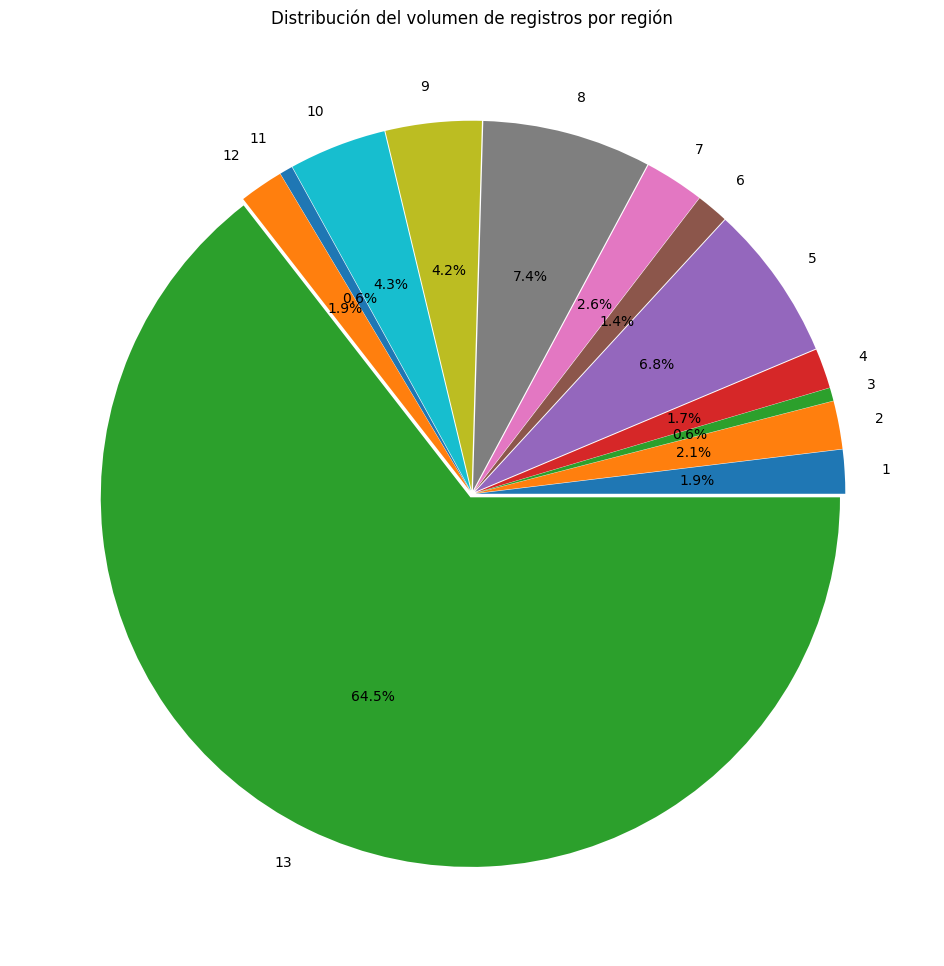

In [79]:
#Formato del grafico circular
datos = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13]

# Separación de cada trozo de la torta al centro 
exp = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

# Etiquetas de cada trozo
m = ["1","2","3","4","5","6","7","8","9","10","11","12","13"]

plt.figure(figsize=(12,12))

plt.title("Distribución del volumen de registros por región")
plt.pie(datos, labels = m, explode = exp, autopct='%2.1f%%')
plt.show()

# Fase 3 - Data Preparation

En la fase de Preparación de Datos consiste en transformar los datos crudos en un formato apto para análisis y modelado. Esto implica limpiar los datos (corrigiendo errores, completando valores faltantes), transformarlos (normalizando, estandarizando), construir muestras representativas y crear nuevas variables si es necesario.

Como pudimos apreciar anteriormente, todas las columnas poseen datos tipo object, por lo tanto, tenemos que transformar cada columna a su mejor tipo de dato. *IMPORTANTE* Por ahora vamos a trabajar solamente con algunas cuantas columnas que utilizaremos para hacer un tipo de testeo de imputación de datos, además de hacer un pequeño análisis antes de explorar todos los datos como conjunto.

In [80]:
# Crear una copia del DataFrame para modificar los tipos de datos
df_nuevos_dtype = df_acotado.copy()

# Columnas que deben ser enteros
columnas_enteros = [
    'Id', 'Edad', 'Region', 'TC', 'Cuentas', 'Hipotecario', 
    'Consumo', 'Debito', 'Ctacte', 'Antiguedad', 'Dualidad', 'target'
]
for col in columnas_enteros:
    df_nuevos_dtype[col] = df_nuevos_dtype[col].astype('int64')

# Convertir columnas de tipo float64
columnas_flotantes = [col for col in df_nuevos_dtype.columns if col not in columnas_enteros + ['Sexo', 'IndRev_T12', 'IndRev_T11', 'IndRev_T10', 'IndRev_T09', 'IndRev_T08', 'IndRev_T07', 'IndRev_T06', 'IndRev_T05', 'IndRev_T04', 'IndRev_T03', 'IndRev_T02', 'IndRev_T01']]
df_nuevos_dtype[columnas_flotantes] = df_nuevos_dtype[columnas_flotantes].astype('float64')

# Convertir columnas de tipo object
columnas_objeto = ['Sexo', 'IndRev_T12', 'IndRev_T11', 'IndRev_T10', 'IndRev_T09', 'IndRev_T08', 'IndRev_T07', 'IndRev_T06', 'IndRev_T05', 'IndRev_T04', 'IndRev_T03', 'IndRev_T02', 'IndRev_T01']
df_nuevos_dtype[columnas_objeto] = df_nuevos_dtype[columnas_objeto].astype('object')

# Verificar tipos de datos
for i in df_nuevos_dtype:
    print(f"{i} = {df_nuevos_dtype[i].dtype} \n")


Id = int64 

Edad = int64 

Renta = float64 

Region = int64 

Sexo = object 

TC = int64 

Cuentas = int64 

Hipotecario = int64 

Consumo = int64 

Debito = int64 

Ctacte = int64 

Antiguedad = int64 

Dualidad = int64 

FacCN_T01 = float64 

FacCN_T02 = float64 

FacCN_T03 = float64 

FacCN_T04 = float64 

FacCN_T05 = float64 

FacCN_T06 = float64 

FacCN_T07 = float64 

FacCN_T08 = float64 

FacCN_T09 = float64 

FacCN_T10 = float64 

FacCN_T11 = float64 

FacCN_T12 = float64 

FacCI_T01 = float64 

FacCI_T02 = float64 

FacCI_T03 = float64 

FacCI_T04 = float64 

FacCI_T05 = float64 

FacCI_T06 = float64 

FacCI_T07 = float64 

FacCI_T08 = float64 

FacCI_T09 = float64 

FacCI_T10 = float64 

FacCI_T11 = float64 

FacCI_T12 = float64 

TxsCN_T01 = float64 

TxsCN_T02 = float64 

TxsCN_T03 = float64 

TxsCN_T04 = float64 

TxsCN_T05 = float64 

TxsCN_T06 = float64 

TxsCN_T07 = float64 

TxsCN_T08 = float64 

TxsCN_T09 = float64 

TxsCN_T10 = float64 

TxsCN_T11 = float64 

TxsCN_

### [MODIFICAR] Ahora vamos a eliminar todas las filas que contengan valor nulo en la columna "Renta" y en la columna "Region", ya que según contexto, todos los clientes ingresados en el Dataset original, tienen alguna relación con la tenencia de tarjeta de crédito, la cual tiene como por prerrequisito, tener una renta mínima en el sistema.

### Tomaremos a la Región 13, ya que concentra la mayor cantidad de datos.

In [81]:
#df_limpio = df_nuevos_dtype.dropna(subset=['Renta'])
#df_limpio = df_nuevos_dtype['Renta'].dropna(inplace=True)

df_acotado_x_region = df_nuevos_dtype[df_nuevos_dtype['Region'] == 13]

In [82]:

for d in df_acotado_x_region:
    print(f"{d} = {df_acotado_x_region[d].info()} \n")
    print(f"{d} = {df_acotado_x_region[d].describe()} \n")

df_acotado_x_region.head(25)

<class 'pandas.core.series.Series'>
Index: 32935 entries, 0 to 51123
Series name: Id
Non-Null Count  Dtype
--------------  -----
32935 non-null  int64
dtypes: int64(1)
memory usage: 514.6 KB
Id = None 

Id = count    32935.000000
mean     25422.027478
std      14808.382727
min          1.000000
25%      12640.500000
50%      25031.000000
75%      38561.500000
max      51124.000000
Name: Id, dtype: float64 

<class 'pandas.core.series.Series'>
Index: 32935 entries, 0 to 51123
Series name: Edad
Non-Null Count  Dtype
--------------  -----
32935 non-null  int64
dtypes: int64(1)
memory usage: 514.6 KB
Edad = None 

Edad = count    32935.000000
mean        38.897161
std         13.204920
min         19.000000
25%         29.000000
50%         35.000000
75%         46.000000
max         97.000000
Name: Edad, dtype: float64 

<class 'pandas.core.series.Series'>
Index: 32935 entries, 0 to 51123
Series name: Renta
Non-Null Count  Dtype  
--------------  -----  
25163 non-null  float64
dtypes: fl

,Id,Edad,Renta,Region,Sexo,TC,Cuentas,Hipotecario,Consumo,Debito,...,IndRev_T10,IndRev_T09,IndRev_T08,IndRev_T07,IndRev_T06,IndRev_T05,IndRev_T04,IndRev_T03,IndRev_T02,IndRev_T01
0,1,43,NaN,13,M,3,1,0,0,1,...,R,R,R,R,R,R,R,R,R,R
1,2,46,143640.0,13,H,1,1,1,0,0,...,R,R,R,R,R,R,R,R,R,R
2,3,45,929106.0,13,H,2,1,1,0,1,...,T,T,T,T,T,T,T,T,T,T
3,4,46,172447.0,13,H,2,1,0,0,0,...,R,R,R,R,R,R,R,R,R,R
4,5,46,805250.0,13,H,3,2,1,0,0,...,T,T,T,T,T,T,T,R,T,R
5,6,47,707664.0,13,H,2,1,0,0,1,...,R,T,T,R,R,R,T,P,R,R
6,7,48,1022833.0,13,H,2,2,0,0,1,...,R,R,R,R,R,R,R,R,R,T
7,8,46,NaN,13,H,3,2,0,0,1,...,T,P,R,R,R,R,R,R,R,R
8,9,49,1171066.0,13,H,1,1,0,0,1,...,R,R,R,R,R,R,R,R,R,R
9,10,44,964387.0,13,M,3,1,1,0,1,...,R,R,R,R,R,R,R,R,R,R


### Vamos a dejar afuera algunas variables que no utilizaremos.

In [83]:
#cantidad_nan_renta = df_acotado_x_region['Renta'].isnull().sum()
##cantidad_nan_region = df_acotado_x_region['Region'].isnull().sum()
#print("Cantidad de NaN en Renta:", cantidad_nan_renta)
#print("Cantidad de NaN en Region:", cantidad_nan_renta)


df_acotado_x_region = df_acotado_x_region.drop(df_acotado_x_region[['Dualidad', 'Consumo', 'Ctacte', 'Debito', 'Hipotecario',
'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 'FacCN_T12',
'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
'TxsCN_T01', 'TxsCN_T02', 'TxsCN_T03', 'TxsCN_T04', 'TxsCN_T05', 'TxsCN_T06', 'TxsCN_T07', 'TxsCN_T08', 'TxsCN_T09', 'TxsCN_T10', 'TxsCN_T11', 'TxsCN_T12',
'TxsCI_T01', 'TxsCI_T02', 'TxsCI_T03', 'TxsCI_T04', 'TxsCI_T05', 'TxsCI_T06', 'TxsCI_T07', 'TxsCI_T08', 'TxsCI_T09', 'TxsCI_T10', 'TxsCI_T11', 'TxsCI_T12',
'UsoL1_T01','UsoL1_T02', 'UsoL1_T03', 'UsoL1_T04', 'UsoL1_T05', 'UsoL1_T06', 'UsoL1_T07', 'UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10', 'UsoL1_T11', 'UsoL1_T12', 
'UsoLI_T01', 'UsoLI_T02', 'UsoLI_T03', 'UsoLI_T04', 'UsoLI_T05', 'UsoLI_T06', 'UsoLI_T07', 'UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10', 'UsoLI_T11', 'UsoLI_T12', 
'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 
'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12', 
'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 
'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12', 
'FlgAct_T01', 'FlgAct_T02', 'FlgAct_T03', 'FlgAct_T04', 'FlgAct_T05', 'FlgAct_T06', 'FlgAct_T07', 
'FlgAct_T08', 'FlgAct_T09', 'FlgAct_T10', 'FlgAct_T11', 'FlgAct_T12', 'FacAN_T01', 'FacAN_T02', 
'FacAN_T03', 'FacAN_T04', 'FacAN_T05', 'FacAN_T06', 'FacAN_T07', 'FacAN_T08', 'FacAN_T09', 
'FacAN_T10', 'FacAN_T11', 'FacAN_T12', 'FacAI_T01', 'FacAI_T02', 'FacAI_T03', 'FacAI_T04', 
'FacAI_T05', 'FacAI_T06', 'FacAI_T07', 'FacAI_T08', 'FacAI_T09', 'FacAI_T10', 'FacAI_T11', 
'FacAI_T12', 'IndRev_T12','IndRev_T11','IndRev_T10','IndRev_T09','IndRev_T08',
'IndRev_T07','IndRev_T06','IndRev_T05','IndRev_T04','IndRev_T03','IndRev_T02','IndRev_T01']], axis=1)

df_acotado_x_region.head(20)

,Id,Edad,Renta,Region,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target
0,1,43,NaN,13,M,3,1,130,798000.0,1210.0,0
1,2,46,143640.0,13,H,1,1,69,750000.0,1000.0,0
2,3,45,929106.0,13,H,2,1,24,1350000.0,1500.0,0
3,4,46,172447.0,13,H,2,1,134,1570800.0,0.0,0
4,5,46,805250.0,13,H,3,2,116,2762000.0,6430.0,0
5,6,47,707664.0,13,H,2,1,67,1312500.0,714.0,0
6,7,48,1022833.0,13,H,2,2,21,813000.0,600.0,0
7,8,46,NaN,13,H,3,2,69,1242000.0,1255.0,0
8,9,49,1171066.0,13,H,1,1,33,1996400.0,2000.0,1
9,10,44,964387.0,13,M,3,1,23,672000.0,1000.0,0


### Revisamos la cantidad de 0s en la columna Region.

In [84]:
# Contar los ceros en la columna Region
cantidad_ceros_region = (df_acotado_x_region['Region'] == 0).sum()

if cantidad_ceros_region > 0:
    print(f"Hay {cantidad_ceros_region} valores 0 en la columna Region.")
else:
    print("No hay valores 0 en la columna Region.")

No hay valores 0 en la columna Region.


### Hacemos una pequeña estadística de los datos por cada columna, para tener mejor idea de los datos con los que estamos trabajando.

In [85]:
for i in df_acotado_x_region:
  print(f"{i} = {df_acotado_x_region[i].describe()} \n")

Id = count    32935.000000
mean     25422.027478
std      14808.382727
min          1.000000
25%      12640.500000
50%      25031.000000
75%      38561.500000
max      51124.000000
Name: Id, dtype: float64 

Edad = count    32935.000000
mean        38.897161
std         13.204920
min         19.000000
25%         29.000000
50%         35.000000
75%         46.000000
max         97.000000
Name: Edad, dtype: float64 

Renta = count    2.516300e+04
mean     6.667516e+05
std      4.001187e+05
min      1.000000e+00
25%      4.209665e+05
50%      5.711190e+05
75%      8.188455e+05
max      8.870997e+06
Name: Renta, dtype: float64 

Region = count    32935.0
mean        13.0
std          0.0
min         13.0
25%         13.0
50%         13.0
75%         13.0
max         13.0
Name: Region, dtype: float64 

Sexo = count     32935
unique        2
top           H
freq      17490
Name: Sexo, dtype: object 

TC = count    32935.000000
mean         1.774677
std          0.902230
min          1.00000

### Revisamos los valor únicos que tiene cada columna.

In [86]:
for i in df_acotado_x_region:
    print(f"{i} = {df_acotado_x_region[i].unique()} \n")

Id = [    1     2     3 ... 51122 51123 51124] 

Edad = [43 46 45 47 48 49 44 38 36 51 37 50 41 39 42 40 32 34 35 33 31 52 53 30
 87 55 29 54 59 69 56 62 60 27 63 28 26 64 25 61 83 86 80 93 79 82 84 97
 88 91 68 89 90 75 57 77 95 67 65 24 22 58 23 71 21 20 19 70 85 73 81 78
 76 72 74 66 94] 

Renta = [    nan 143640. 929106. ... 625376. 806220. 840878.] 

Region = [13] 

Sexo = ['M' 'H'] 

TC = [ 3  1  2  4  5  6  8  7 12 10  9 11] 

Cuentas = [1 2 3 4 5] 

Antiguedad = [130  69  24 134 116  67  21  33  23  38  80  13   7  22  72  94  18 184
  49  14 109 105  27  78  60 152  10  28  19  26  75  70  48  74  15  30
  61  36   8  87  35 145  16  47  20  39   9  25  84  73  92  50  65  99
  96  83  64  59  32 180   6 117  68  93  82 107  79  31  63  53  56  11
  81  58  57  45 188 108  44  37  52  97 119 148  54  41 149  66  71 155
 113  34  29 143  43 110 106 120  85  98  12  51  40  42 140 150 131 101
 127  17  77 122  95  88 100 142 151  86 112  55 121 154 118 137 126  90
  62 133  46 1

## Identificación de Valores Faltantes
### En este paso, identificamos las columnas que contienen valores faltantes dentro del dataset. Esto es importante ya que los algoritmos de Machine Learning generalmente no funcionan bien con datos incompletos. Visualizamos estos valores faltantes usando un mapa de calor para identificar qué columnas requieren atención.

In [87]:
# Revisamos cuántos valores faltantes hay por columna
# Iterar por cada columna del DataFrame
for columna in df_acotado_x_region.columns:
    total_faltantes = df_acotado_x_region[columna].isna().sum()
    porcentaje_faltantes = (df_acotado_x_region[columna].isna().mean() * 100)
    tipo_dato = df_acotado_x_region[columna].dtype

    # Mostrar la información de la columna actual
    print(f"Columna: {columna}")
    print(f"  - Total Faltantes: {total_faltantes}")
    print(f"  - Porcentaje Faltantes: {porcentaje_faltantes:.2f}%")
    print(f"  - Tipo de Dato: {tipo_dato}")
    print("-" * 40)


Columna: Id
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Edad
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Renta
  - Total Faltantes: 7772
  - Porcentaje Faltantes: 23.60%
  - Tipo de Dato: float64
----------------------------------------
Columna: Region
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Sexo
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: object
----------------------------------------
Columna: TC
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Cuentas
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Antiguedad
  - Total Faltantes: 0
  - Porcen

### Eliminamos la columna Región.

In [88]:
df_acotado_x_region = df_acotado_x_region.drop('Region', axis=1)
df_acotado_x_region = df_acotado_x_region.drop('Id', axis=1)
# df_acotado_x_region.to_csv('/Users/herna/Desktop/df_acotado_new.csv')

## Detección y Manejo de Outliers
### Los outliers pueden influir negativamente en los resultados del análisis y el modelado. Aquí, utilizamos el método del rango intercuartil (IQR) para identificar y eliminar los outliers en las variables numéricas, asegurando que no distorsionen las relaciones entre las variables.

Outliers detectados en 'Edad': 737


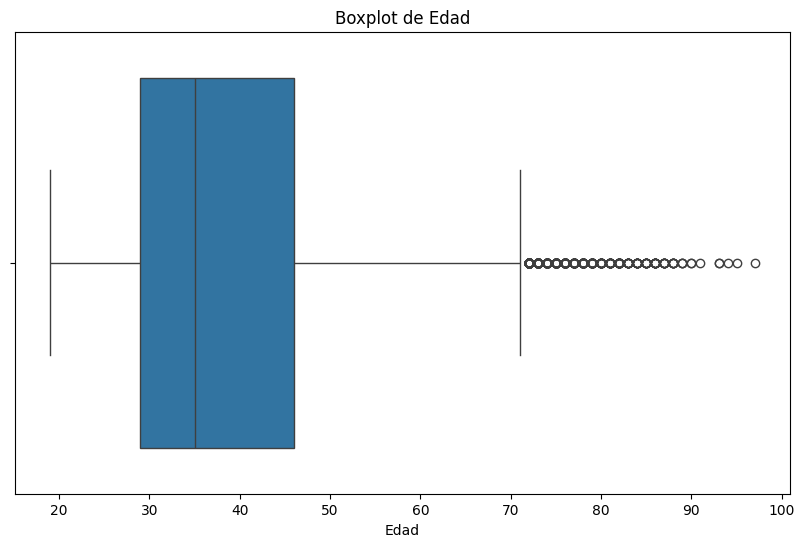

Outliers detectados en 'Renta': 999


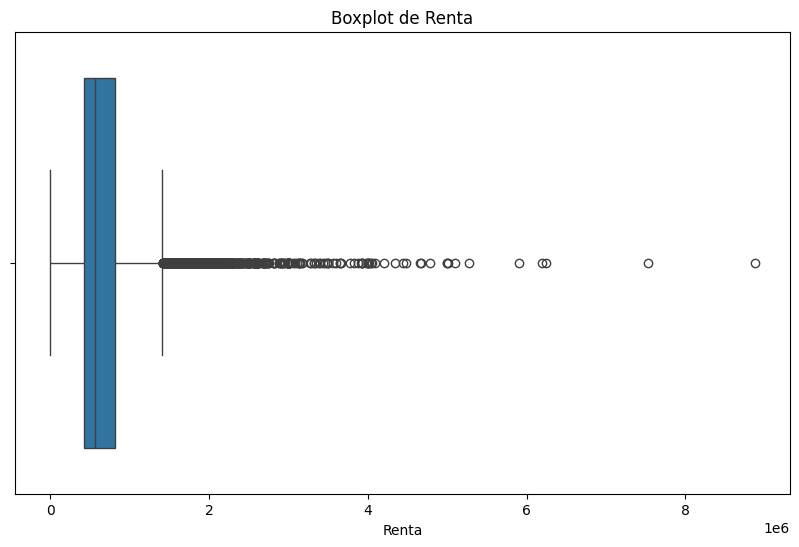

Outliers detectados en 'Antiguedad': 1528


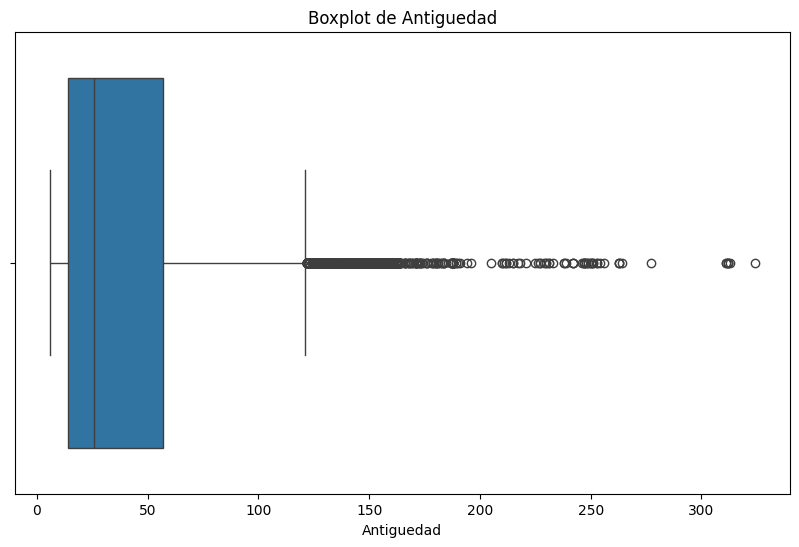

Outliers detectados en 'CUPO_L1': 1547


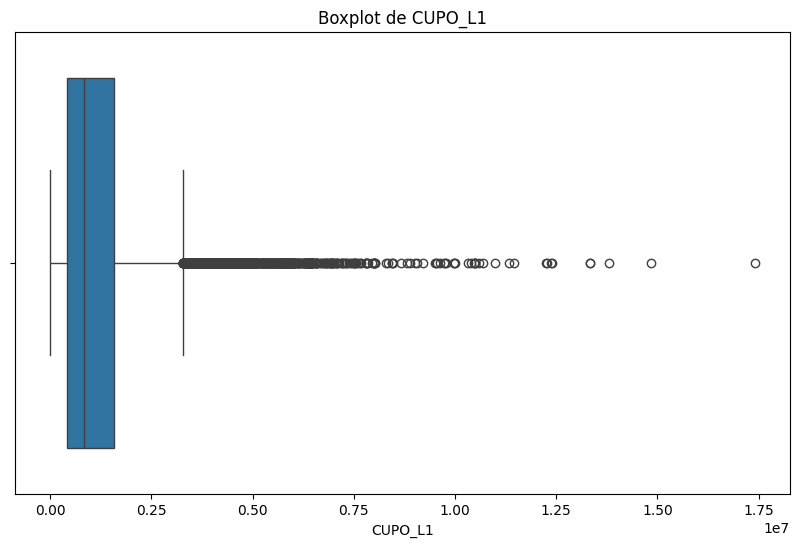

Outliers detectados en 'CUPO_MX': 1803


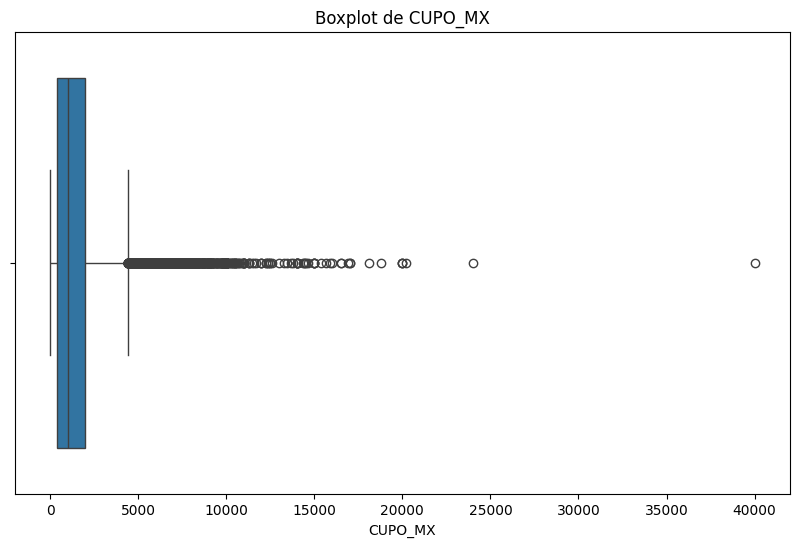

Filas después de eliminar outliers: 28362


,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target
1,46,143640.0,H,1,1,69,750000.0,1000.0,0
2,45,929106.0,H,2,1,24,1350000.0,1500.0,0
5,47,707664.0,H,2,1,67,1312500.0,714.0,0
6,48,1022833.0,H,2,2,21,813000.0,600.0,0
7,46,NaN,H,3,2,69,1242000.0,1255.0,0
8,49,1171066.0,H,1,1,33,1996400.0,2000.0,1
9,44,964387.0,M,3,1,23,672000.0,1000.0,0
12,36,1263238.0,H,1,1,80,500000.0,1500.0,0
14,48,592541.0,H,1,1,13,400000.0,1000.0,0
15,46,NaN,H,2,2,7,800000.0,1200.0,0


In [89]:
# Suponiendo que df_acotado_x_region es el dataframe original
df_acotado_x_region_v2 = df_acotado_x_region.copy()

# Listado de columnas numéricas relevantes para detectar outliers
num_columnas = ['Edad', 'Renta', 'Antiguedad', 'CUPO_L1', 'CUPO_MX']

# Función para detectar outliers con el método IQR en cualquier columna numérica
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    # Definir los límites para identificar los outliers
    outliers = df[(df[columna] < (Q1 - 1.5 * IQR)) | (df[columna] > (Q3 + 1.5 * IQR))]
    return outliers

# Visualización de outliers con gráficos de caja para una columna
def visualizar_outliers(df, columna):
    plt.figure(figsize=(10, 6))
    sb.boxplot(x=df[columna])
    plt.title(f'Boxplot de {columna}')
    plt.show()

# Detección, visualización y eliminación de outliers para todas las columnas numéricas
all_outliers = pd.DataFrame()  # Para acumular todos los outliers detectados

for columnas in num_columnas:
    # Detectar outliers en la columna actual
    outliers_col = detectar_outliers(df_acotado_x_region_v2, columnas)
    print(f"Outliers detectados en '{columnas}': {outliers_col.shape[0]}")
    
    # Visualizar los outliers en la columna actual
    visualizar_outliers(df_acotado_x_region_v2, columnas)
    
    # Acumular los outliers detectados
    all_outliers = pd.concat([all_outliers, outliers_col])

# Eliminar los outliers detectados de todas las columnas
df_acotado_x_region_v2 = df_acotado_x_region_v2[~df_acotado_x_region_v2.index.isin(all_outliers.index)]

# Mostrar el número de filas después de eliminar los outliers
print(f"Filas después de eliminar outliers: {df_acotado_x_region_v2.shape[0]}")

# Ver los primeros 25 registros después de eliminar outliers
df_acotado_x_region_v2.head(25)


### Imputamos con el modelo Regresión Lineal, porque es más confiable que la imputación con la media o mediana, y se basa en las relaciones entre múltiples variables del dataset, haciendo que las imputaciones sean más precisas.

In [90]:
# Separar los datos con y sin valores faltantes en la columna 'Renta'
con_renta = df_acotado_x_region_v2[df_acotado_x_region_v2['Renta'].notnull()]
sin_renta = df_acotado_x_region_v2[df_acotado_x_region_v2['Renta'].isnull()]

# Definir las columnas predictoras (excluimos 'Renta', 'Unnamed: 0', 'target')
predictores = ['Edad', 'Sexo', 'Cuentas', 'Antiguedad']

# Separar las variables predictoras y la variable objetivo ('Renta')
X = con_renta[predictores]
y = con_renta['Renta']

# Preprocesamiento: OneHotEncoding para la columna 'Sexo' (es categórica)
preprocesador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), ['Sexo'])
], remainder='passthrough')

# Crear un pipeline que combine preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocesador),
    ('model', LinearRegression())
])

# Entrenar el modelo de regresión
pipeline.fit(X, y)

# Ahora usamos este modelo para predecir los valores faltantes de 'Renta'
X_faltantes = sin_renta[predictores]

# Predecir los valores de Renta faltantes
renta_pred = pipeline.predict(X_faltantes)

# Imputar los valores predichos en el dataframe original
df_acotado_x_region_v2.loc[df_acotado_x_region_v2['Renta'].isnull(), 'Renta'] = renta_pred

# Mostrar el dataframe con la columna 'Renta' imputada
df_acotado_x_region_v2.head(50)

,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target
1,46,1.436400e+05,H,1,1,69,750000.0,1000.0,0
2,45,9.291060e+05,H,2,1,24,1350000.0,1500.0,0
5,47,7.076640e+05,H,2,1,67,1312500.0,714.0,0
6,48,1.022833e+06,H,2,2,21,813000.0,600.0,0
7,46,6.896734e+05,H,3,2,69,1242000.0,1255.0,0
8,49,1.171066e+06,H,1,1,33,1996400.0,2000.0,1
9,44,9.643870e+05,M,3,1,23,672000.0,1000.0,0
12,36,1.263238e+06,H,1,1,80,500000.0,1500.0,0
14,48,5.925410e+05,H,1,1,13,400000.0,1000.0,0
15,46,6.449081e+05,H,2,2,7,800000.0,1200.0,0


### Vamos a borrar y verificar los nulos en las columnas del Array.

In [91]:
columnas_a_checkear = ['Edad', 'Renta', 'Sexo', 'TC', 'Cuentas', 'Antiguedad', 'CUPO_L1', 'CUPO_MX', 'target']

# Mostrar la cantidad de filas antes de la limpieza
filas_iniciales = df_acotado_x_region_v2.shape[0]

# Eliminar las filas que contengan valores nulos en las columnas seleccionadas
df_acotado_x_region_v2 = df_acotado_x_region_v2.dropna(subset=columnas_a_checkear)

# Mostrar la cantidad de filas después de la limpieza
filas_limpias = df_acotado_x_region_v2.shape[0]

print(f"Filas iniciales: {filas_iniciales}")
print(f"Filas después de eliminar valores nulos en las columnas seleccionadas: {filas_limpias}")

porcentaje_reduccion = ((filas_iniciales / filas_limpias) * 100) - 100
porcentaje_reduccion_redondeado = round(porcentaje_reduccion, 1)

print(f"Porcentaje de reducción de datos: {porcentaje_reduccion_redondeado}%")

df_acotado_x_region_v2.head(50)

Filas iniciales: 28362
Filas después de eliminar valores nulos en las columnas seleccionadas: 28362
Porcentaje de reducción de datos: 0.0%


,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target
1,46,1.436400e+05,H,1,1,69,750000.0,1000.0,0
2,45,9.291060e+05,H,2,1,24,1350000.0,1500.0,0
5,47,7.076640e+05,H,2,1,67,1312500.0,714.0,0
6,48,1.022833e+06,H,2,2,21,813000.0,600.0,0
7,46,6.896734e+05,H,3,2,69,1242000.0,1255.0,0
8,49,1.171066e+06,H,1,1,33,1996400.0,2000.0,1
9,44,9.643870e+05,M,3,1,23,672000.0,1000.0,0
12,36,1.263238e+06,H,1,1,80,500000.0,1500.0,0
14,48,5.925410e+05,H,1,1,13,400000.0,1000.0,0
15,46,6.449081e+05,H,2,2,7,800000.0,1200.0,0


## Codificación de Variables Categóricas
### Para poder utilizar las variables categóricas en modelos de Machine Learning, es necesario transformarlas en representaciones numéricas. Para esto, utilizamos **Label Encoding** para variables categóricas con pocos valores (como 'Sexo')

In [92]:
# Ver los valores únicos de la columna 'Region'
print(df_acotado_x_region_v2['Sexo'].unique())

# Ver la cantidad de valores únicos
print(f"Cantidad de valores únicos: {df_acotado_x_region_v2['Sexo'].nunique()}")

# Revisar si hay valores nulos en la columna 'Region'
print(f"Cantidad de valores nulos: {df_acotado_x_region_v2['Sexo'].isnull().sum()}")

# Hacer un conteo de la cantidad de veces que aparece cada valor único en la columna 'Region'
print(df_acotado_x_region_v2['Sexo'].value_counts())

['H' 'M']
Cantidad de valores únicos: 2
Cantidad de valores nulos: 0
Sexo
H    14685
M    13677
Name: count, dtype: int64


In [93]:
# Usamos Label Encoding para 'Sexo', ya que solo tiene unos pocos valores
label_encoder = LabelEncoder()
df_acotado_x_region_v2['Sexo'] = label_encoder.fit_transform(df_acotado_x_region_v2['Sexo'])
df_preparado = df_acotado_x_region_v2

df_preparado.head(20)

,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target
1,46,1.436400e+05,0,1,1,69,750000.0,1000.0,0
2,45,9.291060e+05,0,2,1,24,1350000.0,1500.0,0
5,47,7.076640e+05,0,2,1,67,1312500.0,714.0,0
6,48,1.022833e+06,0,2,2,21,813000.0,600.0,0
7,46,6.896734e+05,0,3,2,69,1242000.0,1255.0,0
8,49,1.171066e+06,0,1,1,33,1996400.0,2000.0,1
9,44,9.643870e+05,1,3,1,23,672000.0,1000.0,0
12,36,1.263238e+06,0,1,1,80,500000.0,1500.0,0
14,48,5.925410e+05,0,1,1,13,400000.0,1000.0,0
15,46,6.449081e+05,0,2,2,7,800000.0,1200.0,0


### Ahora salió una incógnita, ya que utilizamos el label encoding para las columnas, necesitamos primeramente identificar qué valores entre 0 y 1 serán los sexos "Masculino" y "Femenino"

In [94]:
columnas_interes = ['Sexo']

conteo_ceros = df_preparado[columnas_interes].apply(lambda x: (x == True).sum())
conteo_unos = df_preparado[columnas_interes].apply(lambda x: (x == False).sum())
conteo_dos = df_preparado[columnas_interes].apply(lambda x: (x.isna()).sum())

resultados_conteo = pd.DataFrame({
    '0': conteo_ceros, # Femenino
    '1': conteo_unos, # Masculino
    '2': conteo_dos # EN el caso de haber quedado valores nulos.

})

print(resultados_conteo)
print("El valor con mayor cantidad serán los hombres ya que logramos apreciar anteriormente que hay más clientes de sexo masculino")
resultados_conteo.head(50)

          0      1  2
0                    
Sexo  13677  14685  0
El valor con mayor cantidad serán los hombres ya que logramos apreciar anteriormente que hay más clientes de sexo masculino


,0,1,2
0,,,
Sexo,13677,14685,0


In [95]:
df_preparado.apply(lambda col: print(f"\nDescripción de la columna '{col.name}':\n", col.describe()))


Descripción de la columna 'Edad':
 count    28362.000000
mean        36.684543
std         11.344304
min         19.000000
25%         28.000000
50%         33.000000
75%         43.000000
max         71.000000
Name: Edad, dtype: float64

Descripción de la columna 'Renta':
 count    2.836200e+04
mean     5.998911e+05
std      2.351658e+05
min      1.000000e+00
25%      4.495662e+05
50%      5.675099e+05
75%      7.022698e+05
max      1.414396e+06
Name: Renta, dtype: float64

Descripción de la columna 'Sexo':
 count    28362.000000
mean         0.482230
std          0.499693
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Sexo, dtype: float64

Descripción de la columna 'TC':
 count    28362.000000
mean         1.729109
std          0.862701
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: TC, dtype: float64

Descripción de la columna 'Cuentas':
 count  

0
Edad          None
Renta         None
Sexo          None
TC            None
Cuentas       None
Antiguedad    None
CUPO_L1       None
CUPO_MX       None
target        None
dtype: object

In [96]:
# Filtrar filas que no contengan valores negativos
df_filtrado = df_preparado[(df_preparado >= 0).all(axis=1)]


# Mostrar las primeras filas del dataframe filtrado
df_filtrado.head(50)

,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target
1,46,1.436400e+05,0,1,1,69,750000.0,1000.0,0
2,45,9.291060e+05,0,2,1,24,1350000.0,1500.0,0
5,47,7.076640e+05,0,2,1,67,1312500.0,714.0,0
6,48,1.022833e+06,0,2,2,21,813000.0,600.0,0
7,46,6.896734e+05,0,3,2,69,1242000.0,1255.0,0
8,49,1.171066e+06,0,1,1,33,1996400.0,2000.0,1
9,44,9.643870e+05,1,3,1,23,672000.0,1000.0,0
12,36,1.263238e+06,0,1,1,80,500000.0,1500.0,0
14,48,5.925410e+05,0,1,1,13,400000.0,1000.0,0
15,46,6.449081e+05,0,2,2,7,800000.0,1200.0,0


In [97]:
df_filtrado.apply(lambda col: print(f"\nDescripción de la columna '{col.name}':\n", col.describe()))
df_filtrado['Renta'].astype(np.int64).count()


Descripción de la columna 'Edad':
 count    28362.000000
mean        36.684543
std         11.344304
min         19.000000
25%         28.000000
50%         33.000000
75%         43.000000
max         71.000000
Name: Edad, dtype: float64

Descripción de la columna 'Renta':
 count    2.836200e+04
mean     5.998911e+05
std      2.351658e+05
min      1.000000e+00
25%      4.495662e+05
50%      5.675099e+05
75%      7.022698e+05
max      1.414396e+06
Name: Renta, dtype: float64

Descripción de la columna 'Sexo':
 count    28362.000000
mean         0.482230
std          0.499693
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Sexo, dtype: float64

Descripción de la columna 'TC':
 count    28362.000000
mean         1.729109
std          0.862701
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: TC, dtype: float64

Descripción de la columna 'Cuentas':
 count  

28362

In [98]:
# Revisamos cuántos valores faltantes hay por columna
# Iterar por cada columna del DataFrame
for columna in df_filtrado.columns:
    total_faltantes = df_filtrado[columna].isna().sum()
    porcentaje_faltantes = (df_filtrado[columna].isna().mean() * 100)
    tipo_dato = df_filtrado[columna].dtype

    # Mostrar la información de la columna actual
    print(f"Columna: {columna}")
    print(f"  - Total Faltantes: {total_faltantes}")
    print(f"  - Porcentaje Faltantes: {porcentaje_faltantes:.2f}%")
    print(f"  - Tipo de Dato: {tipo_dato}")
    print("-" * 40)

df_filtrado.head(50)

Columna: Edad
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Renta
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: float64
----------------------------------------
Columna: Sexo
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int32
----------------------------------------
Columna: TC
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Cuentas
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Antiguedad
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: CUPO_L1
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: float64
----------------------------------------
Columna: CUPO_MX
  - Total Faltantes: 0
  - Por

,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target
1,46,1.436400e+05,0,1,1,69,750000.0,1000.0,0
2,45,9.291060e+05,0,2,1,24,1350000.0,1500.0,0
5,47,7.076640e+05,0,2,1,67,1312500.0,714.0,0
6,48,1.022833e+06,0,2,2,21,813000.0,600.0,0
7,46,6.896734e+05,0,3,2,69,1242000.0,1255.0,0
8,49,1.171066e+06,0,1,1,33,1996400.0,2000.0,1
9,44,9.643870e+05,1,3,1,23,672000.0,1000.0,0
12,36,1.263238e+06,0,1,1,80,500000.0,1500.0,0
14,48,5.925410e+05,0,1,1,13,400000.0,1000.0,0
15,46,6.449081e+05,0,2,2,7,800000.0,1200.0,0


### Revisaremos con gráficas el dataframe para guiarnos en los siguientes pasos.

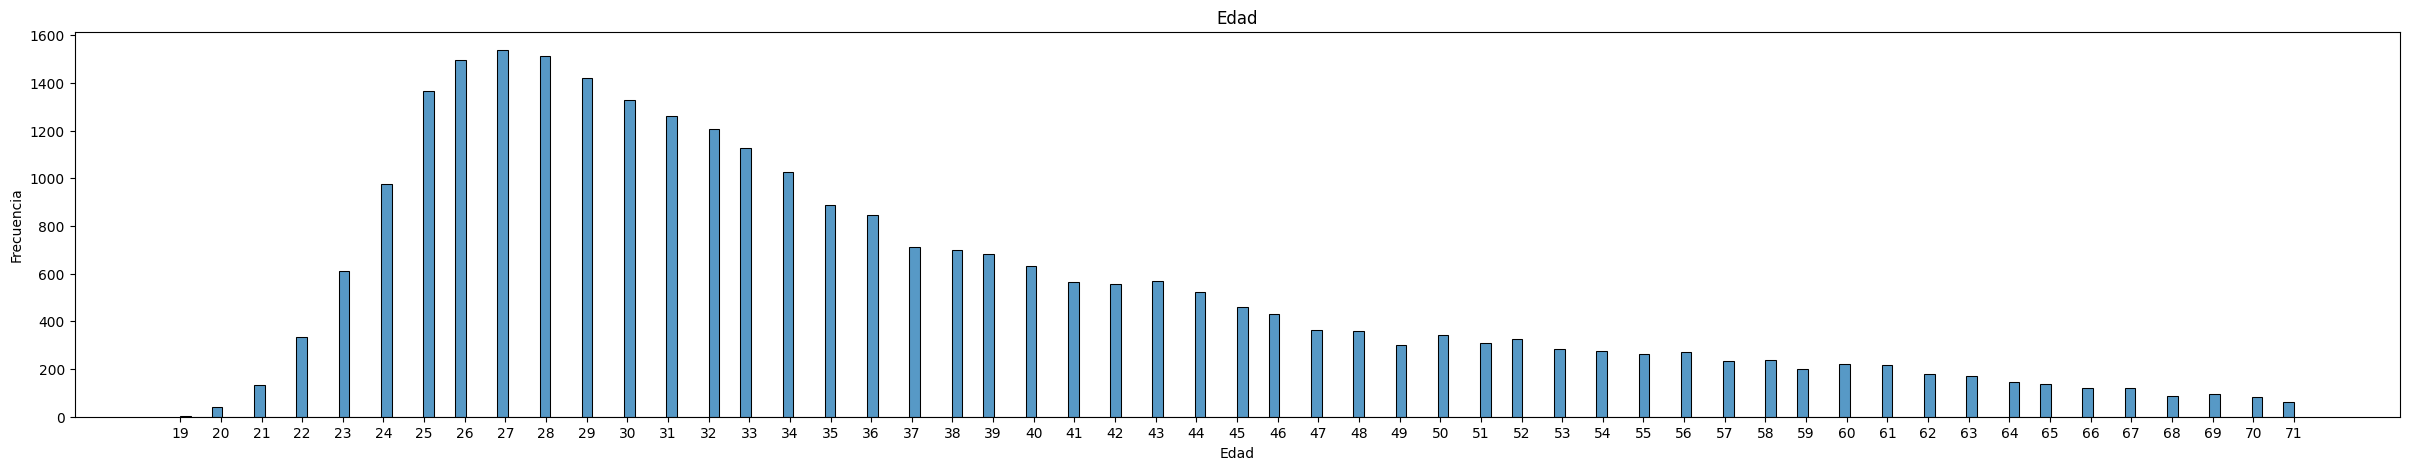

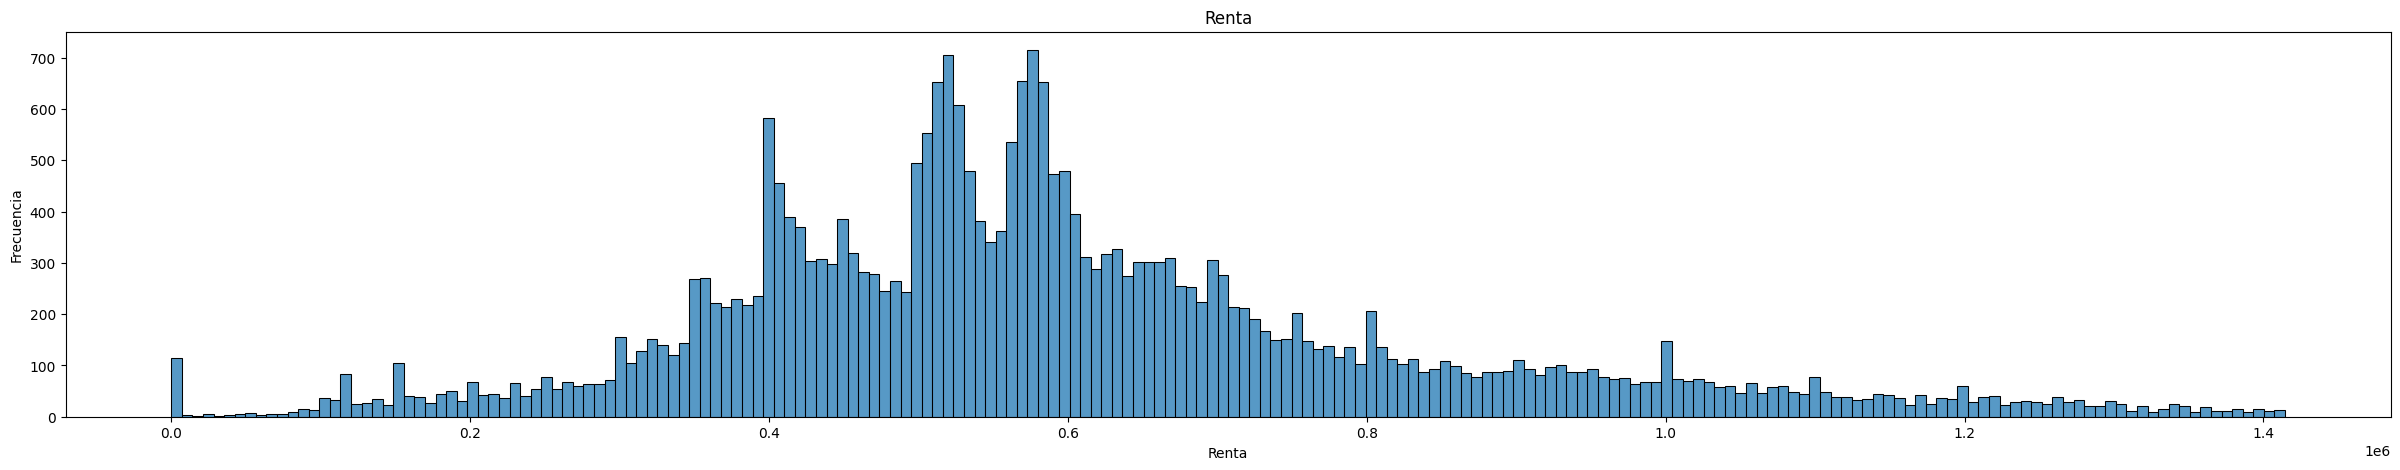

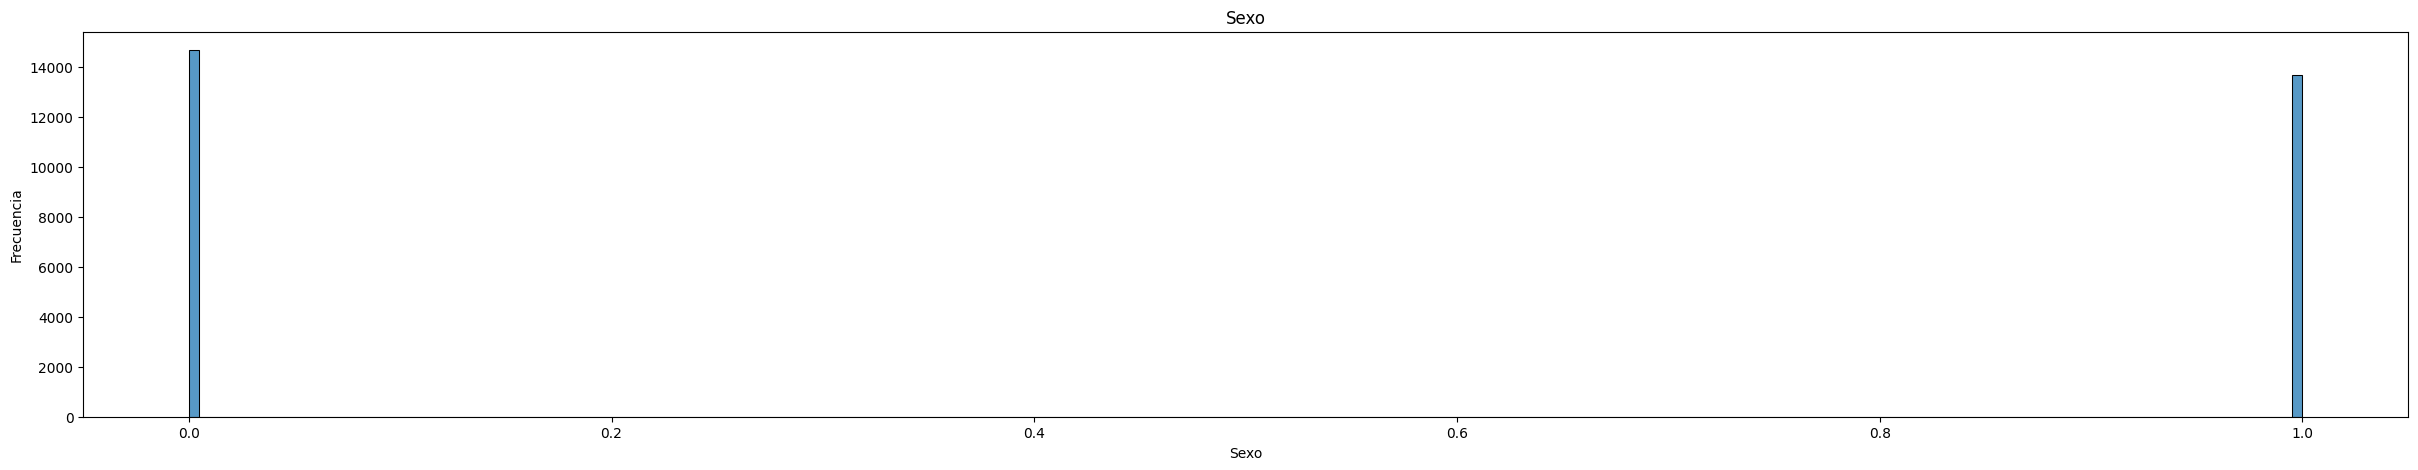

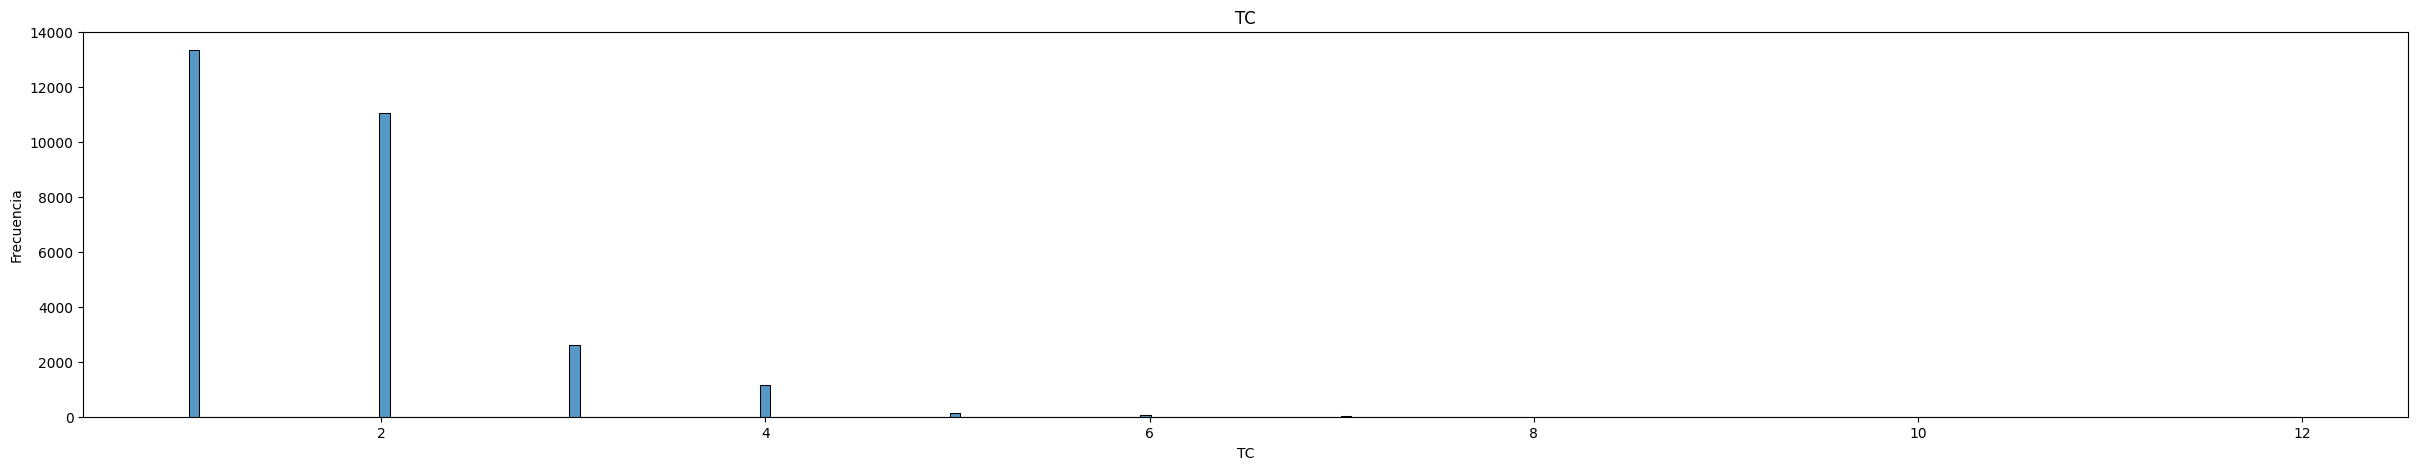

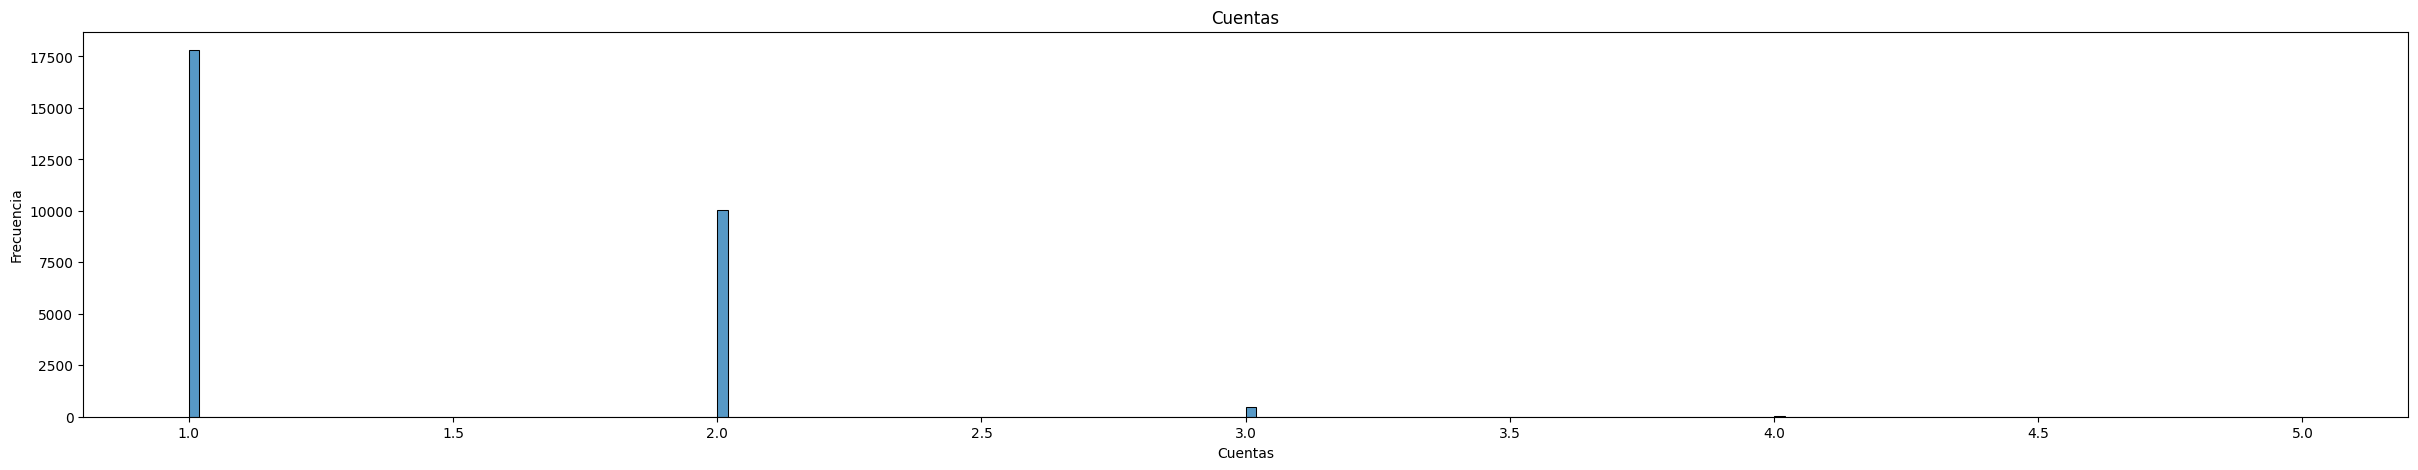

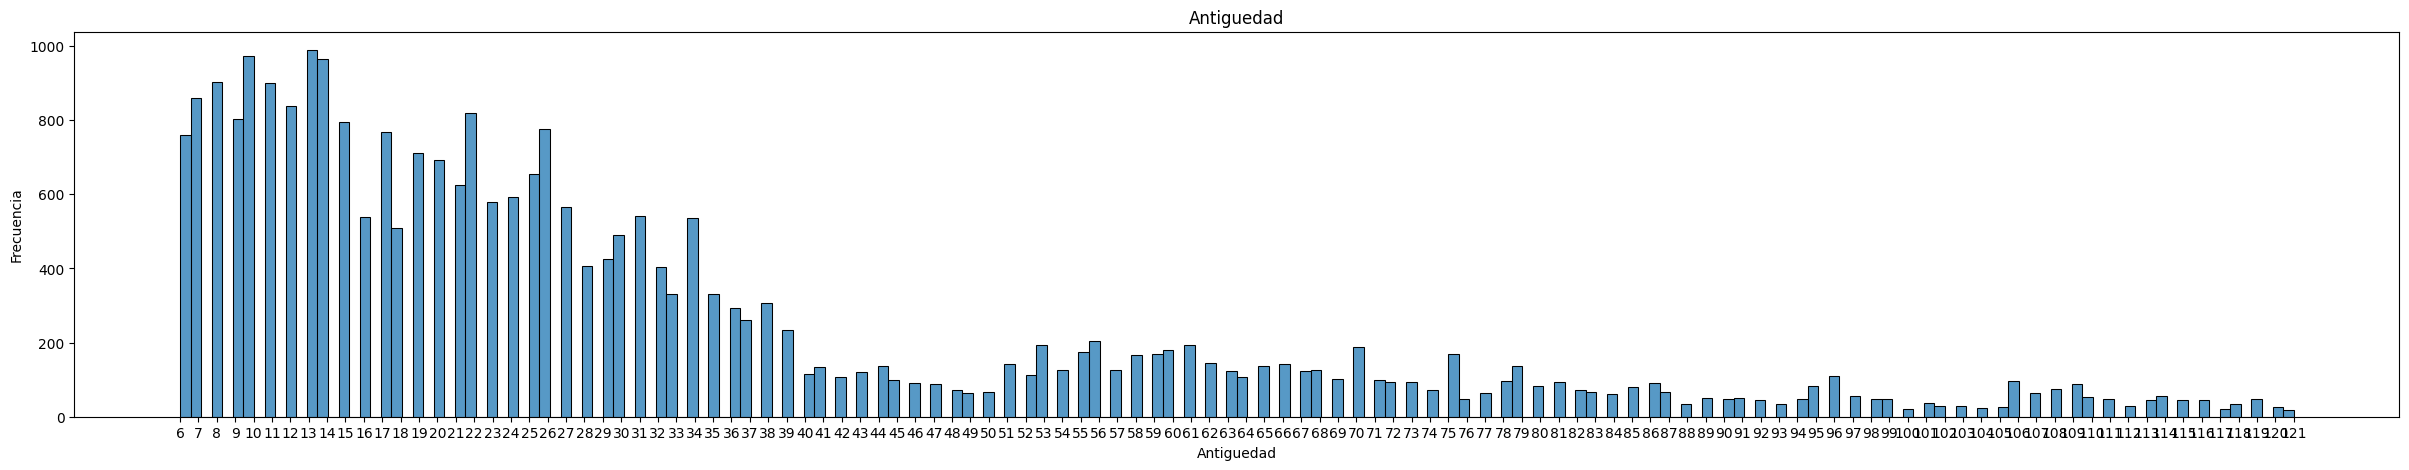

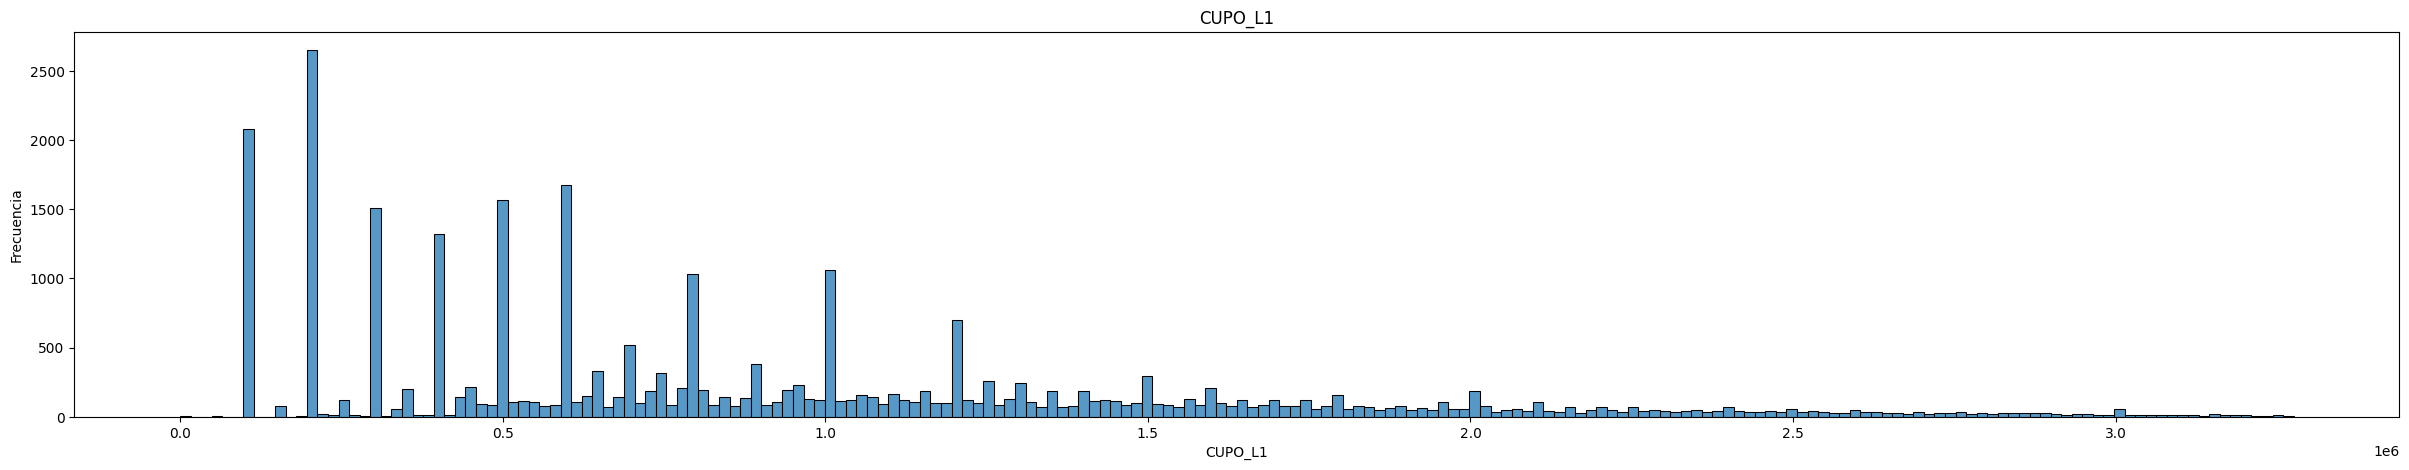

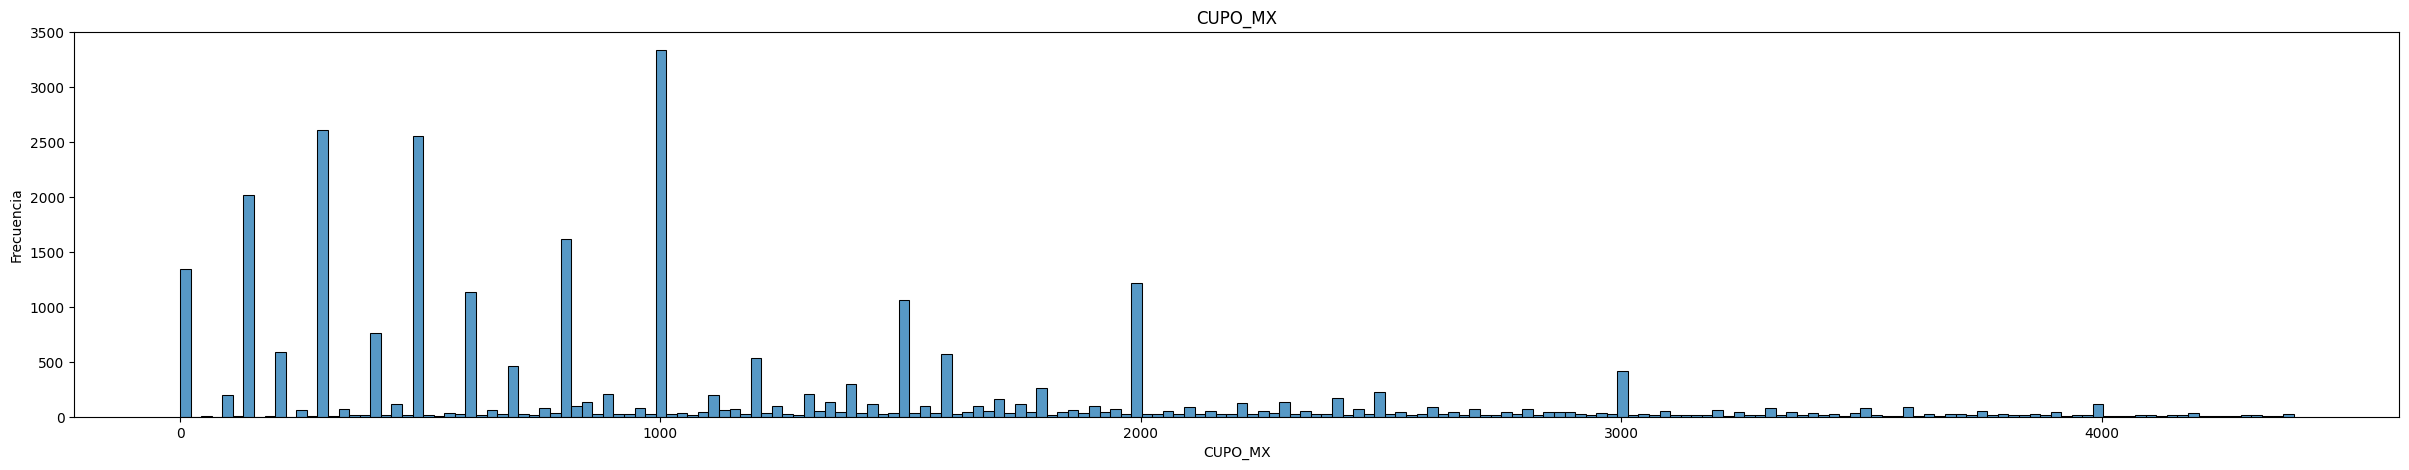

In [99]:
# Definimos las columnas que queremos analizar en detalle
columnas_para_filtrar = ['Edad', 'Region', 'Antiguedad']

# Iteramos sobre cada columna del DataFrame, excluyendo un gran conjunto de columnas
for columna in df_filtrado.drop(df_filtrado[['target']], axis=1):
    plt.figure(figsize=(30, 5))
    sb.histplot(df_filtrado[columna], bins=200)
    plt.title(columna)
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

    # Si la columna está en la lista de columnas a filtrar, ajustamos los límites de los ejes x
    if columna in columnas_para_filtrar:
        valor_max = df_filtrado[columna].max()
        valor_min = df_filtrado[columna].min()
        plt.xticks(np.arange(valor_min, valor_max + 1, step=1))
        plt.show()

## Seleccionaremos características

In [100]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28362 entries, 1 to 51123
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        28362 non-null  int64  
 1   Renta       28362 non-null  float64
 2   Sexo        28362 non-null  int32  
 3   TC          28362 non-null  int64  
 4   Cuentas     28362 non-null  int64  
 5   Antiguedad  28362 non-null  int64  
 6   CUPO_L1     28362 non-null  float64
 7   CUPO_MX     28362 non-null  float64
 8   target      28362 non-null  int64  
dtypes: float64(3), int32(1), int64(5)
memory usage: 2.1 MB


In [101]:
df_filtrado_v2 = df_filtrado.copy()

X = df_filtrado_v2.drop(columns=['Renta'])
y = df_filtrado_v2['Renta']

### Mostramos las 12 características más relevantes para la predicción de la variable objetivo "y" en un conjunto de datos "X" utilizando una prueba estadística de regresión.

In [102]:
mejores_cat = SelectKBest(score_func=f_regression, k=12)
fit = mejores_cat.fit(X, y)

puntaje_df = pd.DataFrame(fit.scores_)
columnas_df = pd.DataFrame(X.columns)

puntajes_cat = pd.concat([columnas_df, puntaje_df], axis=1)
puntajes_cat.columns = ['Descripción', 'Resultado']

puntajes_cat.nlargest(12, 'Resultado')

C:\Users\new11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=12 is greater than n_features=8. All the features will be returned.
  warnings.warn(


,Descripción,Resultado
5,CUPO_L1,2419.667116
6,CUPO_MX,2018.981429
0,Edad,999.742218
4,Antiguedad,565.746145
1,Sexo,406.118257
2,TC,47.843271
3,Cuentas,27.879612
7,target,0.364288


### Obtenemos importancia de características.

In [103]:
modelo = ExtraTreesRegressor()
modelo.fit(X, y)

ExtraTreesRegressor()

In [104]:
print(modelo.feature_importances_)

[0.21507554 0.01654247 0.06190841 0.02741572 0.23265262 0.2391879
 0.1833439  0.02387345]


Mostramos gráficamente.

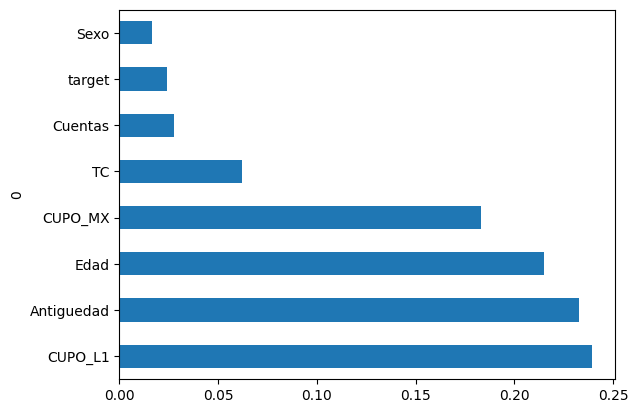

In [109]:
importancia_cat = pd.Series(modelo.feature_importances_, index=X.columns)
importancia_cat.nlargest(14).plot(kind='barh')
plt.show()

### Normalizaremos el dataset.

In [110]:
# Copia del DataFrame original
df_normalizado = df_filtrado_v2.copy()

# Separar las columnas que van a usarse con StandardScaler
col_standard = ['Edad', 'Antiguedad', 'CUPO_L1', 'CUPO_MX', 'Cuentas', 'Sexo', 'TC']

# Inicializar los escaladores
scaler_standard = StandardScaler()
#scaler_minmax = MinMaxScaler()

# Aplicar StandardScaler
df_normalizado[col_standard] = scaler_standard.fit_transform(df_normalizado[col_standard])

# Aplicar MinMaxScaler
#df_normalizado[col_minmax] = scaler_minmax.fit_transform(df_normalizado[col_minmax])

#df_normalizado.to_csv('/Users/herna/Desktop/df_normalizado.csv')

In [111]:
df_normalizado.head(20)

,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target
1,0.821172,1.436400e+05,-0.965069,-0.845162,-0.740532,1.392253,-0.244402,-0.108680,0
2,0.733020,9.291060e+05,-0.965069,0.314009,-0.740532,-0.327557,0.620634,0.423156,0
5,0.909323,7.076640e+05,-0.965069,0.314009,-0.740532,1.315817,0.566569,-0.412890,0
6,0.997475,1.022833e+06,-0.965069,0.314009,1.150776,-0.442211,-0.153573,-0.534148,0
7,0.821172,6.896734e+05,-0.965069,1.473179,1.150776,1.392253,0.464927,0.162557,0
8,1.085626,1.171066e+06,-0.965069,-0.845162,-0.740532,0.016405,1.552565,0.954992,1
9,0.644869,9.643870e+05,1.036195,1.473179,-0.740532,-0.365775,-0.356856,-0.108680,0
12,-0.060343,1.263238e+06,-0.965069,-0.845162,-0.740532,1.812651,-0.604833,0.423156,0
14,0.997475,5.925410e+05,-0.965069,-0.845162,-0.740532,-0.747955,-0.749006,-0.108680,0
15,0.821172,6.449081e+05,-0.965069,0.314009,1.150776,-0.977263,-0.172315,0.104055,0


# Modeling

# Evaluation

# Deployment